# 2023-hceres: HAL Data processing (PHARE / CRI)

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import unidecode
import json
import re
from typing import Any, Dict, List, Callable, Optional, Union, Pattern
import textwrap
import logging
import time, datetime
import os
import difflib

In [2]:
logging.basicConfig(
    format='[%(asctime)s][%(levelname)-5s][%(funcName)s#%(lineno)s] %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    level=logging.INFO,
)
LOGGER = logging.getLogger(__name__)
LOGGER.info('Logger loaded')

[2023-03-03 14:43:41][INFO ][<module>#7] Logger loaded


# Definitions

## Constants

Define primary constants

* `LAB_STRUCT_ID` : The identifier in HAL of the CES (15080)
* `NON_ALPHA_NUMERIC_REGEX` : Regex to cleanup all non alpha numeric characters
* `JSON_FILENAME` : Extration from HAL API.
* `CURRENT_TIMESTAMP`: The current timestamp of the last run of this notebook (used to retrieve some refenrentials)


In [3]:
# PHARE: 542292
LAB_STRUCT_ID = 542292
# CRI: 
#LAB_STRUCT_ID = 74131
NON_ALPHA_NUMERIC_REGEX = re.compile('[^a-z0-9_-]', re.IGNORECASE)
JSON_FILENAME = './result.phare.2023-03-03T11-54.json'
CURRENT_TIMESTAMP = datetime.datetime.now().timestamp()

## Functions

In [4]:
# As an alternative, we might extends pandas the official way
# See: https://pandas.pydata.org/docs/development/extending.html#extending-pandas

class DfOps(pd.core.frame.DataFrame):
    
    def __init__(
        self,
        dataframe: pd.core.frame.DataFrame,
        prefix: Optional[str] = None
    ) -> None:
        super().__init__(dataframe)
        self._prefix = (prefix or '').strip('_ ')
    
    def _display(self, df: pd.core.frame.DataFrame) -> 'DfOps':
        import IPython.display as display
        display.display(df)
        return self

    def display(self) -> 'DfOps':
        return self._display(self)
    
    def display_head(self, n=5) -> 'DfOps':
        return self._display(self.head(n=n))
    
    def _target_file(self, filename:str, ext: str) -> str:
        target_file = f'{self._prefix}_{filename}'.strip('_ ')
        target_file = re.compile('[^a-z0-9\.-]+', re.IGNORECASE).sub('_', target_file)
        target_file = re.compile(f'\.{ext}$', re.IGNORECASE).sub('', target_file)
        target_file = f'./exports/{target_file}.{ext.lower()}'
        return target_file
        
    def csv(self, filename: str, index=True, **kwargs) -> 'DfOps':
        target_file = self._target_file(filename=filename, ext='csv')
        to_csv_params = { 'index': index, **kwargs }
        LOGGER.info("Export to CSV file: %s (params: %s) (number of rows: %d)", target_file, to_csv_params, len(self))
        self.to_csv(target_file, **to_csv_params)
        return self
    
    def count(self, subset: List[str], column: str, dropna: bool = False) -> 'DfOps':
        return DfOps(self.value_counts(subset=subset, dropna=dropna).to_frame(name=column).reset_index())
    
    def barh(
        self,
        x: str,
        y: str,
        title: str,
        sort_by: List[str] = [],
        plot_params: Dict[str, Any] = None,
        title_params: Dict[str, Any] = None,
        sort_params: Dict[str, Any] = None,
    ) -> 'DfOps':
        sort_by = sort_by or [ y ]
        plot_params = plot_params or {}
        title_params = title_params or {}
        sort_params = sort_params or {}
        
        result_sort_params = {**dict(by=sort_by, ascending=True), **sort_params}
        LOGGER.debug('Sort current dataframe for graph "%s" => sort_params=%s', title, result_sort_params)
        sorted_df = self.sort_values(**result_sort_params)
        
        result_plot_params = {
            **dict(legend=False, xlabel='', ylabel='', figsize=(8, 4), rot=0, fontsize=12), # Default params
            **plot_params, # Override params
            **dict(kind='barh', title=title, x=x) # Forced params
        }
        
        LOGGER.debug('Create barh graph for "%s" => plot_params=%s)', title, result_plot_params)
        p = sorted_df.plot(**result_plot_params)
        
        default_title_params = dict(pad=20, fontdict={'fontsize': 16})
        result_title_params = {**default_title_params, **title_params}
        LOGGER.debug('Set title "%s" of current barh graph => title_params=%s', title, result_title_params)
        p.set_title(title, **result_title_params)
        plt.tight_layout()
        
        target_file = self._target_file(filename=title, ext='png').lower()
        LOGGER.info("Export barh graph to PNG file: %s", target_file)
        p.get_figure().savefig(target_file)
        plt.show()
        
        return DfOps(sorted_df)
    
    def pie(
        self,
        label_column: str,
        column: str,
        title: str,
        sort_by: List[str] = [],
        plot_params: Dict[str, Any] = None,
        title_params: Dict[str, Any] = None,
        sort_params: Dict[str, Any] = None,
    ) -> 'DfOps':
        sort_by = sort_by or [ column ]
        plot_params = plot_params or {}
        title_params = title_params or {}
        sort_params = sort_params or {}
        
        result_sort_params = {**dict(by=sort_by), **sort_params}
        LOGGER.debug('Sort current dataframe for graph "%s" => sort_params=%s', title, result_sort_params)
        sorted_df = self.sort_values(**result_sort_params)
        
        result_plot_params = {
            **dict(
                subplots=True,
                sharex=False,
                sharey=False,
                labels=sorted_df[label_column],
                figsize=(12, 12),
                autopct=lambda p: '{total} ({p:.2f}%)'.format(p=p, total=round(p * self[column].sum() / 100)),
                pctdistance=0.8,
                legend=False,
            ),
            **plot_params,
            **dict(kind='pie', subplots=True, y=column)
        }
        LOGGER.debug('Create pie graph for "%s" => plot_params=%s)', title, result_plot_params)
        axs = sorted_df.plot(**result_plot_params)
        plt.tight_layout()
        axs[0].set_ylabel('')
        
        default_title_params = dict(y=1.0, pad=-14, fontdict={'fontsize': 16})
        result_title_params = {**default_title_params, **title_params}
        LOGGER.debug('Set title "%s" of current pie graph => title_params=%s', title, result_title_params)
        axs[0].set_title(title, **result_title_params)
        
        target_file = self._target_file(f'{title}.png', 'png').lower() 
        LOGGER.info("Export pie graph to PNG file: %s", target_file)
        plt.figure(1).savefig(target_file)
        plt.show() 
        return DfOps(sorted_df)

    def group_min_values(
        self,
        label_column: str,
        value_column: str = 'count',
        min_value: Union[float, int] = 0,
        min_label: Callable[[List[Any]], str] = lambda l: f'Others ({len(l)})',
        export_title: Optional[str] = None,
    ) -> 'DfOps':
        
        # Retrieve small dataframe to create a new 'others' row
        dataframe_others = self[(self[value_column] <= min_value)]
        dataframe_others_labels = dataframe_others[label_column].to_list()
        dateframe_others_sum = dataframe_others[value_column].sum()
        dataframe_others = pd.DataFrame(
            dict([
                (label_column, min_label(dataframe_others_labels)),
                (value_column, dateframe_others_sum)
            ]),
            index=[0]
        )
        LOGGER.info(
            'Create a new dataframe for other values (others=(col[\'%s\'] < %s]) => %d rows aggreated',
            value_column, str(min_value), len(dataframe_others_labels)
        )
        if export_title:
            DfOps(dataframe_others, prefix=f'{export_title}_grouped_{value_column}').csv(filename='others.csv', index=False) 
        
        # From base dataframe, retrieve the top values
        dataframe_top = self[(self[value_column] > min_value)]
        if export_title:
            DfOps(dataframe_top, prefix=f'{export_title}_grouped_{value_column}').csv(filename='top.csv', index=False) 
            
        # Concat the 2 DfOps
        dataframe_result = pd.concat([dataframe_top, dataframe_others], ignore_index=True)
        dataframe_result = DfOps(dataframe_result.sort_values(by=[value_column], ascending=False), prefix=f'{export_title or ""}_grouped_{value_column}')
        LOGGER.info('New dataframe size: %d (Original dataframe size: %d)', len(dataframe_result), len(self))
        if export_title:
            dataframe_result.csv(filename='all.csv', index=False) 
            
        return DfOps(dataframe_result)

#  Datasets

This dataset has been saved by another notebook : `extract-data-to-json.ipynb`

Here, we just load the data. For more information, see [./extract-data-to-json.ipynb](./extract-data-to-json.ipynb) another


## HAL APIs

### Load HAL API results

Load the HAP API results from filaneme named `JSON_FILENAME`

In [5]:
with open(JSON_FILENAME, 'r') as fp:
    data = json.load(fp)
df = pd.DataFrame.from_dict(data['response']['docs'])
df

,label_s,openAccess_bool,jel_s,keyword_s,authLastName_s,authFirstName_s,authFullName_s,authIdFullName_fs,authIdHal_i,authIdHasPrimaryStructure_fs,...,audience_s,journalTitle_s,journalIssn_s,funding_s,europeanProjectAcronym_s,europeanProjectReference_s,anrProjectTitle_s,anrProjectAcronym_s,anrProjectReference_s,authStructId_i
0,Pierre Januard. Risks on Trade: The Activity o...,True,[B],"[Thomas Aquinas, Scholastics, Trade, Merchant,...",[Januard],[Pierre],[Pierre Januard],[1133802_FacetSep_Pierre Januard],[1133802],[1987654-1133802_FacetSep_Pierre Januard_JoinS...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Pierre Januard. Risks on Trade: The Activity o...,False,NaN,NaN,[Januard],[Pierre],[Pierre Januard],[1133802_FacetSep_Pierre Januard],[1133802],[1987654-1133802_FacetSep_Pierre Januard_JoinS...,...,2,History of Economic Ideas,1122-8792,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Laurent Jaffro. Forgiveness and Weak Agency. P...,True,NaN,"[Wager, Forgiveness, Agency, Intertemporal cho...",[Jaffro],[Laurent],[Laurent Jaffro],[238_FacetSep_Laurent Jaffro],[238],[13991-238_FacetSep_Laurent Jaffro_JoinSep_542...,...,2,Proceedings of the Aristotelian Society,0066-7374,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Victor Bianchini. De la nécessité de l’anthrop...,False,NaN,NaN,[Bianchini],[Victor],[Victor Bianchini],[1182088_FacetSep_Victor Bianchini],[1182088],[1249151-1182088_FacetSep_Victor Bianchini_Joi...,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Claire Pignol. « Comment les écrivains parlent...,False,NaN,NaN,[Pignol],[Claire],[Claire Pignol],[1120145_FacetSep_Claire Pignol],[1120145],[1263935-1120145_FacetSep_Claire Pignol_JoinSe...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,"Aurélien Goutsmedt, Goulven Rubin. Robert J. G...",True,NaN,NaN,"[Goutsmedt, Rubin]","[Aurélien, Goulven]","[Aurélien Goutsmedt, Goulven Rubin]","[16665_FacetSep_Aurélien Goutsmedt, 1120147_Fa...","[16665, 1120147]",[19847-16665_FacetSep_Aurélien Goutsmedt_JoinS...,...,2,History of Economic Ideas,1122-8792,NaN,NaN,NaN,NaN,NaN,NaN,NaN
301,"Emmanuelle Benicourt, Sophie Jallais, Camille ...",False,"[A, D, B]","[Economics education, Microeconomics textbooks...","[Benicourt, Jallais, Noûs]","[Emmanuelle, Sophie, Camille]","[Emmanuelle Benicourt, Sophie Jallais, Camille...","[848496_FacetSep_Emmanuelle Benicourt, 9106_Fa...","[848496, 9106, 183511]",[310219-848496_FacetSep_Emmanuelle Benicourt_J...,...,2,Real-World Economics Review,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
302,"Cinla Akdere, Christine Baron. “Monetary Relat...",False,NaN,NaN,"[Akdere, Baron]","[Cinla, Christine]","[Cinla Akdere, Christine Baron]","[0_FacetSep_Cinla Akdere, 182916_FacetSep_Chri...",[182916],[2744684-0_FacetSep_Cinla Akdere_JoinSep_54229...,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
303,"Claire Pignol, Benoît Walraevens. Book Review:...",False,NaN,NaN,"[Pignol, Walraevens]","[Claire, Benoît]","[Claire Pignol, Benoît Walraevens]","[1120145_FacetSep_Claire Pignol, 172955_FacetS...","[1120145, 172955]",[1263935-1120145_FacetSep_Claire Pignol_JoinSe...,...,2,European Journal of the History of Economic Th...,0967-2567,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Stats

View some minor stats on non nan row for each columns

In [6]:
# List all non nan row for each columns
DfOps(df.count().to_frame()).csv('rows-having-values.csv', index=True)

[2023-03-03 14:43:41][INFO ][csv#35] Export to CSV file: ./exports/rows-having-values.csv (params: {'index': True}) (number of rows: 30)


,0
label_s,305
openAccess_bool,305
jel_s,51
keyword_s,179
authLastName_s,305
authFirstName_s,305
authFullName_s,305
authIdFullName_fs,305
authIdHal_i,262
authIdHasPrimaryStructure_fs,305


## Authors Datasets

In this section, we will work on the authors to find all name forms.

This came from HAL Extractions.


### All authors (from HAL)...


In [7]:
# Cleanup useles columns for authors and explode on same list length
authors = df[['authLastName_s', 'authFirstName_s', 'authFullName_s']]
authors = authors.explode(['authLastName_s', 'authFirstName_s', 'authFullName_s'])
authors = authors.drop_duplicates(ignore_index=True)
DfOps(authors).csv('authors-all.csv', index=False)

[2023-03-03 14:43:41][INFO ][csv#35] Export to CSV file: ./exports/authors-all.csv (params: {'index': False}) (number of rows: 130)


,authLastName_s,authFirstName_s,authFullName_s
0,Januard,Pierre,Pierre Januard
1,Jaffro,Laurent,Laurent Jaffro
2,Bianchini,Victor,Victor Bianchini
3,Pignol,Claire,Claire Pignol
4,Guillot,Léon,Léon Guillot
...,...,...,...
125,Freitas,Vinícius França,Vinícius França Freitas
126,Kober-Smith,Anémone,Anémone Kober-Smith
127,Leydier,Gilles,Gilles Leydier
128,Benicourt,Emmanuelle,Emmanuelle Benicourt


### Current structure (from HAL)


As an author may have multiple structures, the number of items in `auth*` columns will not be the same !

We will have the same length in the following list :

* `authId_i`, `authLastName_s`, `authFirstName_s`, `authFullName_s`
* `authStructId_i`, `authIdHasPrimaryStructure_fs`

But the length of list `authId_i` and `authStructId_i` may be different.

We will use the facet `authIdHasPrimaryStructure_fs` to correlate an author with its `authStructId_i`.

At the end, we will produces 2 DataFrames:
* `struct_authors`: contains all the authors of the current structure
* `similarity_struct_authors`: contains all authors similarity

In [8]:
def fs_struct_authors(dataframe: pd.core.frame.DataFrame, column: str, pattern: Pattern) -> pd.core.frame.DataFrame:
    # Select only column of interest
    ndf = dataframe[['authFullName_s', 'authFirstName_s', 'authLastName_s', column]]
    ndf = ndf.explode(['authLastName_s', 'authFirstName_s', 'authFullName_s']).explode([column]).drop_duplicates(ignore_index=True)
    ndf[[f'{column}_fullName', f'{column}_structId']] = ndf[column].str.extract(pattern)
    ndf = ndf.astype({f'{column}_structId': 'int'})
    # Correlate with authFullName_s
    ndf = ndf[ndf[f'{column}_fullName'] == ndf['authFullName_s']]
    # And structure id
    ndf = ndf[ndf[f'{column}_structId'] == LAB_STRUCT_ID]
    ndf = ndf.drop(columns=[column, f'{column}_fullName', f'{column}_structId']).drop_duplicates(ignore_index=True)
    return DfOps(ndf).csv(filename=f'authors-struct-{LAB_STRUCT_ID}-{column}.csv', index=False)

In [9]:
fs_auth_id_has_structure_authors = fs_struct_authors(
    dataframe=df,
    column='authIdHasStructure_fs',
    pattern=r'^.*_FacetSep_(?P<fullName>.*)_JoinSep_(?P<structId>\d+)_FacetSep_.*$'
)
fs_auth_id_has_primary_structure_authors = fs_struct_authors(
    dataframe=df,
    column='authIdHasPrimaryStructure_fs',
    pattern=r'^.*_FacetSep_(?P<fullName>.*)_JoinSep_(?P<structId>\d+)_FacetSep_.*$'
)
struct_authors = pd.concat([fs_auth_id_has_structure_authors, fs_auth_id_has_primary_structure_authors]) \
    .drop_duplicates(ignore_index=True) \
    .sort_values(by=['authLastName_s', 'authFirstName_s', 'authFullName_s']) \
    .reset_index(drop=True)
struct_authors = DfOps(struct_authors).csv(f'authors-struct-{LAB_STRUCT_ID}.csv', index=False)
struct_authors

[2023-03-03 14:43:41][INFO ][csv#35] Export to CSV file: ./exports/authors-struct-542292-authIdHasStructure_fs.csv (params: {'index': False}) (number of rows: 44)
[2023-03-03 14:43:42][INFO ][csv#35] Export to CSV file: ./exports/authors-struct-542292-authIdHasPrimaryStructure_fs.csv (params: {'index': False}) (number of rows: 44)
[2023-03-03 14:43:42][INFO ][csv#35] Export to CSV file: ./exports/authors-struct-542292.csv (params: {'index': False}) (number of rows: 44)


,authFullName_s,authFirstName_s,authLastName_s
0,Cinla Akdere,Cinla,Akdere
1,Çinla Akdere,Çinla,Akdere
2,Michael Assous,Michael,Assous
3,Michaël Assous,Michaël,Assous
4,Victor Bianchini,Victor,Bianchini
5,Céline Bouillot,Céline,Bouillot
6,Laurie Bréban,Laurie,Bréban
7,Hélène Bénistand,Hélène,Bénistand
8,Marie Daou,Marie,Daou
9,Jean Dellemotte,Jean,Dellemotte


### Author names similarities (in HAL)

In [10]:
# will be better with faster with levenstein distance.
# Anyway, we will use what's in python builtin modules...
similarity_struct_authors = struct_authors.merge(struct_authors, how="cross", suffixes=('', '_alt')) # This will make a very big DataFrame !!
similarity_struct_authors = similarity_struct_authors[
    (similarity_struct_authors.authFullName_s != similarity_struct_authors.authFullName_s_alt)
    | (similarity_struct_authors.authLastName_s != similarity_struct_authors.authLastName_s_alt)
    | (similarity_struct_authors.authFirstName_s != similarity_struct_authors.authFirstName_s_alt)
]
similarity_struct_authors['similarity'] = similarity_struct_authors.apply(
    lambda r: difflib.SequenceMatcher(None, r['authFullName_s'], r['authFullName_s_alt']).ratio(), 
    axis=1
)
similarity_struct_authors = similarity_struct_authors.reset_index(drop=True)
DfOps(similarity_struct_authors[similarity_struct_authors.similarity > 0.8]).csv(f'authors-struct-{LAB_STRUCT_ID}-similarity-over-0.8.csv')

[2023-03-03 14:43:42][INFO ][csv#35] Export to CSV file: ./exports/authors-struct-542292-similarity-over-0.8.csv (params: {'index': True}) (number of rows: 14)


,authFullName_s,authFirstName_s,authLastName_s,authFullName_s_alt,authFirstName_s_alt,authLastName_s_alt,similarity
0,Cinla Akdere,Cinla,Akdere,Çinla Akdere,Çinla,Akdere,0.916667
43,Çinla Akdere,Çinla,Akdere,Cinla Akdere,Cinla,Akdere,0.916667
88,Michael Assous,Michael,Assous,Michaël Assous,Michaël,Assous,0.928571
131,Michaël Assous,Michaël,Assous,Michael Assous,Michael,Assous,0.928571
572,Ariane Dupont Kieffer,Ariane,Dupont Kieffer,Ariane Dupont-Kieffer,Ariane,Dupont-Kieffer,0.952381
581,Ariane Dupont Kieffer,Ariane,Dupont Kieffer,Ariane Dupont Kieffer,Ariane Dupont,Kieffer,1.000000
615,Ariane Dupont-Kieffer,Ariane,Dupont-Kieffer,Ariane Dupont Kieffer,Ariane,Dupont Kieffer,0.952381
624,Ariane Dupont-Kieffer,Ariane,Dupont-Kieffer,Ariane Dupont Kieffer,Ariane Dupont,Kieffer,0.952381
704,Vinícius França Freitas,Vinícius,França Freitas,Vinícius França Freitas,Vinícius França,Freitas,1.000000
747,Vinícius França Freitas,Vinícius França,Freitas,Vinícius França Freitas,Vinícius,França Freitas,1.000000


## Rerefentials Datasets

In [11]:
# datetime.timedelta(days=1).total_seconds() = 86400
def download_referential(target_file: str, ref_url: str, delta: int = 86400):
    mtime = 0
    if os.path.exists(target_file):
        mtime = os.path.getmtime(target_file)

    LOGGER.info('%s modification time %d (current timestamp: %d)', target_file, mtime, CURRENT_TIMESTAMP)

    if CURRENT_TIMESTAMP - mtime > delta:
        LOGGER.info('Download %s referential at %s', target_file, ref_url)
        resp = requests.get(ref_url);
        resp.status_code
        if resp.status_code == 200:
            with open(target_file, 'wb') as fd:
                fd.write(resp.content)
            LOGGER.info('URL Content %s has been saved to file: %s', ref_url, target_file)
        else:
            LOGGER.error('Cannot retrieve file %s. Status Code: %d', target_file, resp.status_code)
    else:
        LOGGER.info('Skipping download of file %s as it has been modified %d seconds ago', target_file, max(0, CURRENT_TIMESTAMP - mtime))

### Econlit

EconLit referential is available at https://www.aeaweb.org/econlit/journal_list.php .

#### HTML Parsing

A JSON Datasets can be extract from a web browser (such as Chrome or Firefox) using the simple following commands in a web console:

```javascript
$$('.journaldesc')
  .map(item => $(item).text().split('\n'))
  .map(arr => Object.assign(
    { Title: arr[0].trim() },
    Object.fromEntries(
      arr
      .slice(1)
      .map(val => val.trim())
      .map(line => [
        line.split(':', 1).join().trim(),
        line.split(':').slice(1).join(':').trim()
      ]))
  ));
```

This will extract all the required code in a object that can be copy/paste into a JSON file

**Note 1 :** It's possible to have some ISSN duplicated here. For example, `0013-0117` have several titles (_Economic History Review_ or _Economic History Review, Second Series_)

**Note 2 :** For formating purpose, `$$` should be replace with a single `$`

#### CSV Export

For a long time, it wasn't possible to retrieve an export of the Econlit referential. So, we did it using a simple javasript export ! Even if it was working pretty well, Econlit evolved and now we have a real CSV export of the Econlit referential.

In [12]:
download_referential(target_file='./ref.econlit.csv', ref_url='https://www.aeaweb.org/journals/econlit-journals/export')

[2023-03-03 14:43:42][INFO ][download_referential#7] ./ref.econlit.csv modification time 1677845009 (current timestamp: 1677854621)
[2023-03-03 14:43:42][INFO ][download_referential#20] Skipping download of file ./ref.econlit.csv as it has been modified 9612 seconds ago


In [13]:
econlit_df = pd.read_csv('./ref.econlit.csv').drop(columns=['EconLit Coverage', 'Formerly', 'See']).rename(columns={'Name': 'Title'})
LOGGER.info('Econlit original size : %d', econlit_df["Title"].size)
# Cleaning data
#econlit_df['ISSN'] = econlit_df['ISSN'].transform(lambda x: x.strip())
econlit_df = econlit_df.drop_duplicates(subset=['ISSN'], ignore_index=True)
LOGGER.info('Econlit size after droping duplicates : %d', econlit_df["Title"].size)
econlit_df

[2023-03-03 14:43:42][INFO ][<module>#2] Econlit original size : 2036
[2023-03-03 14:43:42][INFO ][<module>#6] Econlit size after droping duplicates : 1908


,Title,URL,ISSN
0,4OR: A Quarterly Journal of Operations Research,https://link.springer.com/journal/volumesAndIs...,1619-4500
1,Academia Economic Papers,https://www.econ.sinica.edu.tw/posts/137,1018-161X
2,"Accounting, Business and Financial History",NaN,0958-5206
3,"Accounting, Economics, and Law: A Convivium",http://www.degruyter.com/view/j/ael,2194-6051
4,Accounting History Review,http://www.tandfonline.com/loi/rabf21,2155-2851
...,...,...,...
1903,Zeitschrift für Wirtschafts- und Sozialwissens...,NaN,0342-1783
1904,Zeitschrift für Wirtschafts- und Unternehmense...,NaN,1439-880X
1905,Zeitschrift für Wirtschaftspolitik,https://www.degruyter.com/journal/key/zfwp/html,0721-3808
1906,Zhournal Novoi Ekonomicheskoi Associacii/Journ...,http://www.econorus.org/enjarchive.phtml,2221-2264


### MathSciNet

MathSciNet referential is available at https://mathscinet.ams.org/mathscinet/mrcit/journal_list.html


#### HTML Parsing

A JSON Datasets can be extract from browser using the simple following commands in a web console:

```javascript
$$('table tr')
  .map(i => $(i).find('td'))
  .filter(a => a.length === 4)
  .map(a => ({
    ISSN: $(a[0]).text().trim(),
    Title: $(a[1]).text().trim(),
    Publisher: $(a[2]).text().trim(),
    Start_Year: $(a[3]).text().trim()
  }))
```

**Note 1:** We may have duplicates in `ISSN` columns

In [14]:
mathscinet_df = pd.read_json('./ref.mathscinet.json').drop(columns=['Publisher', 'Start_Year'])
print(f'MathSciNet original size : {mathscinet_df["Title"].size}')
mathscinet_df['ISSN'] = mathscinet_df['ISSN'].transform(lambda x: x.strip())
mathscinet_df = mathscinet_df.drop_duplicates(subset=['ISSN'], ignore_index=True)
print(f'MathSciNet size after cleaning duplicates : {mathscinet_df["Title"].size}')
mathscinet_df

MathSciNet original size : 765
MathSciNet size after cleaning duplicates : 617


,ISSN,Title
0,0271-4132,Contemp. Math.
1,0302-9743,Lecture Notes in Comput. Sci.
2,0160-7634,Proc. Sympos. Appl. Math.
3,0082-0717,Proc. Sympos. Pure Math.
4,0025-5858,Abh. Math. Semin. Univ. Hambg.
...,...,...
612,0165-2125,Wave Motion
613,0044-2267,ZAMM Z. Angew. Math. Mech.
614,0232-2064,Z. Anal. Anwend.
615,0044-2275,Z. Angew. Math. Phys.


### Scimago JCR

A CSV is already available on the [scimago website](https://www.scimagojr.com/journalrank.php) and can be donwload with the following links: https://www.scimagojr.com/journalrank.php?out=xls


**Note :** The `Issn` columns may contains multiples ISSN 

In [15]:
download_referential(target_file='./ref.scimagojr_2021.csv', ref_url='https://www.scimagojr.com/journalrank.php?out=xls')

[2023-03-03 14:43:42][INFO ][download_referential#7] ./ref.scimagojr_2021.csv modification time 1677845012 (current timestamp: 1677854621)
[2023-03-03 14:43:42][INFO ][download_referential#20] Skipping download of file ./ref.scimagojr_2021.csv as it has been modified 9609 seconds ago


In [16]:
scimagojr_df = pd.read_csv('./ref.scimagojr_2021.csv', sep=';')[['Title', 'Issn', 'Categories', 'SJR Best Quartile']]
scimagojr_df = scimagojr_df.rename(columns={'Issn': 'ISSNs', 'SJR Best Quartile': 'SJR_BEST_QUARTILE', 'Categories': 'CATEGORIES'})
LOGGER.info('Scimago original size: %d', scimagojr_df["Title"].size)

scimagojr_df['ISSN'] = scimagojr_df['ISSNs'].apply(lambda x: x.split(','))
scimagojr_df = scimagojr_df.explode('ISSN')
LOGGER.info('Scimago size after exploding "ISSNs" columns: %d', scimagojr_df["Title"].size)

scimagojr_df['ISSN'] = scimagojr_df['ISSN'].transform(lambda x: '-'.join(textwrap.wrap(x.strip(),4)))
scimagojr_df = scimagojr_df.drop(columns=['ISSNs']).drop_duplicates(subset=['ISSN'], ignore_index=True)
LOGGER.info('Scimago size after exploding "ISSNs" and droping duplicates: %d', scimagojr_df["Title"].size)

scimagojr_df

[2023-03-03 14:43:42][INFO ][<module>#3] Scimago original size: 27339
[2023-03-03 14:43:42][INFO ][<module>#7] Scimago size after exploding "ISSNs" columns: 43410
[2023-03-03 14:43:42][INFO ][<module>#11] Scimago size after exploding "ISSNs" and droping duplicates: 43369


,Title,CATEGORIES,SJR_BEST_QUARTILE,ISSN
0,Ca-A Cancer Journal for Clinicians,Hematology (Q1); Oncology (Q1),Q1,1542-4863
1,Ca-A Cancer Journal for Clinicians,Hematology (Q1); Oncology (Q1),Q1,0007-9235
2,Nature Reviews Molecular Cell Biology,Cell Biology (Q1); Molecular Biology (Q1),Q1,1471-0072
3,Nature Reviews Molecular Cell Biology,Cell Biology (Q1); Molecular Biology (Q1),Q1,1471-0080
4,Quarterly Journal of Economics,Economics and Econometrics (Q1),Q1,0033-5533
...,...,...,...,...
43364,WSEAS Transactions on Information Science and ...,Computer Science Applications; Information Sys...,-,1790-0832
43365,WSEAS Transactions on Systems,Computer Science Applications; Control and Sys...,-,1109-2777
43366,Z Badan nad Ksiazka i Ksiegozbiorami Historycz...,Arts and Humanities (miscellaneous); Communica...,-,2544-8730
43367,Z Badan nad Ksiazka i Ksiegozbiorami Historycz...,Arts and Humanities (miscellaneous); Communica...,-,1897-0788


### HCERES Vague B 2021


#### PDF Export

Arf, this is most painfull format (a old school PDF) ! This should be done (almost) manually...

The current file is available here:
https://www.hceres.fr/sites/default/files/media/downloads/hceres_2021_liste_domaine_shs1_economie_et_gestion.pdf

**Steps :**

* Extract a flat text of the PDF
* Remove useles data such as the presentation, the page numbers, ...
* Replace using regex :
  * Searched: `^(.{9})\s+(.*)\s+([^\s]+)\s+([^\s]+)\s+([^\s]+)\s?$`
  * Replacement: `{"ISSN":"$1", "Title": "$2", "CoNRS_2020": "$3"; "FNEGE_2019": "$4", "HCERES_2021": "$5" },`
* Remove the `,` char at the end of the document
* Append `[` char at the beginning and `]` at the end of the document

**Note :** We may have duplicates in `ISSN` columns

In [17]:
hceres_df = pd.read_json('./ref.hceres.json')
LOGGER.info('HCERES original size: %d', hceres_df["Title"].size)

hceres_df['ISSN'] = hceres_df['ISSN'].transform(lambda x: x.strip())
hceres_df = hceres_df.drop_duplicates(subset=['ISSN'], ignore_index=True)
hceres_df = hceres_df.replace('-', np.nan)
LOGGER.info('HCERES size after cleaning duplicates: %d', hceres_df["Title"].size)

hceres_df

[2023-03-03 14:43:42][INFO ][<module>#2] HCERES original size: 937
[2023-03-03 14:43:42][INFO ][<module>#7] HCERES size after cleaning duplicates: 924


,ISSN,Title,CoNRS_2020,FNEGE_2019,HCERES_2021
0,2034-9130,@GRH,NaN,3,B
1,1619-4500,4OR: A Quarterly Journal of Operations Research,3,NaN,B
2,0001-3072,Abacus,3,2,A
3,1941-6520,Academy of Management Annals,2,1,A
4,0001-4273,Academy of Management Journal,1,1,A
...,...,...,...,...,...
919,1011-4548,World Competition. Law and Economics Review,3,NaN,B
920,0305-750X,World Development,1,NaN,A
921,0378-5920,World Economy,2,NaN,A
922,1474-7456,World Trade Review,4,NaN,C


### CNRS Section 37 Juin 2020

In [18]:
cnrs_s37_df = pd.read_json('./ref.cnrs-s37-juin-2020.json')
cnrs_s37_df = cnrs_s37_df.rename(columns={'issn': 'ISSN', 'title': 'Title'})
LOGGER.info('CNRS Section 37 original size: %d', len(cnrs_s37_df))
cnrs_s37_df

[2023-03-03 14:43:42][INFO ][<module>#3] CNRS Section 37 original size: 843


,Title,ISSN,domaine,cat
0,4OR: A Quarterly Journal of Operations Research,1619-4500,RO,3
1,Abacus,0001-3072,CPT,3
2,Academy of Management Annals,1941-6520,GEN,2
3,Academy of Management Journal,0001-4273,GEN,1
4,Academy of Management Learning and Education,1537-260X,GEN,2
...,...,...,...,...
838,World Competition. Law and Economics Review,1011-4548,EcoDroit,3
839,World Development,0305-750X,DevTrans,1
840,World Economy,0378-5920,Macro,2
841,World Trade Review,1474-7456,Macro,4


# All documents types

## Document type distribution

[2023-03-03 14:43:42][INFO ][csv#35] Export to CSV file: ./exports/document_types.csv (params: {'index': False}) (number of rows: 11)
[2023-03-03 14:43:42][INFO ][barh#77] Export barh graph to PNG file: ./exports/distribution_by_types.png


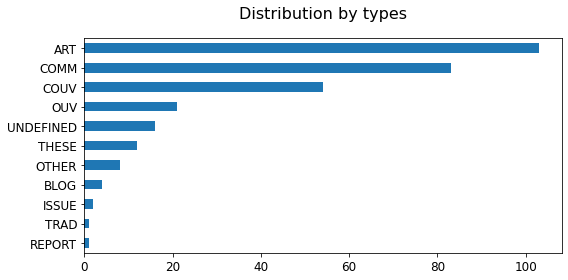

[2023-03-03 14:43:42][INFO ][<module>#5] Number of document without docType_s: 0
[2023-03-03 14:43:42][INFO ][<module>#6] Number of document types: 11


,docType_s,count
9,REPORT,1
10,TRAD,1
8,ISSUE,2
7,BLOG,4
6,OTHER,8
5,THESE,12
4,UNDEFINED,16
3,OUV,21
2,COUV,54
1,COMM,83


In [19]:
doc_types = DfOps(df) \
    .count(subset=['docType_s'], column='count') \
    .csv('document_types.csv', index=False) \
    .barh(title='Distribution by types', x='docType_s', y='count')
LOGGER.info('Number of document without docType_s: %d', doc_types[doc_types.docType_s.isnull()]["count"].sum())
LOGGER.info('Number of document types: %d', doc_types["docType_s"].dropna().size)
doc_types

In [20]:
doc_types_others = DfOps(doc_types).group_min_values(
    label_column = 'docType_s',
    value_column = 'count',
    min_value = 5,
    min_label = lambda l: f'{" + ".join(l)}'
)
doc_types_others

[2023-03-03 14:43:42][INFO ][group_min_values#152] Create a new dataframe for other values (others=(col['count'] < 5]) => 4 rows aggreated
[2023-03-03 14:43:42][INFO ][group_min_values#167] New dataframe size: 8 (Original dataframe size: 11)


,docType_s,count
6,ART,103
5,COMM,83
4,COUV,54
3,OUV,21
2,UNDEFINED,16
1,THESE,12
0,OTHER,8
7,REPORT + TRAD + ISSUE + BLOG,8


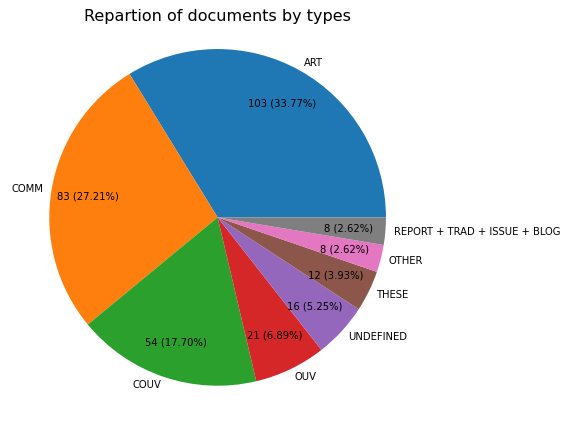

In [21]:
axs = doc_types_others['count'].plot(
    kind='pie',
    subplots=True,
    sharex=False,
    sharey=False,
    #title='Occurence',
    labels=doc_types_others['docType_s'],
    figsize=(8, 8),
    #autopct='%1.1f%%',
    autopct=lambda p: '{total} ({p:.2f}%)'.format(p=p, total=round(p * doc_types_others['count'].sum() / 100)),
    pctdistance=0.78,
    #rotatelabels=False,
    labeldistance=1.05
)
plt.tight_layout()
#plt.figure(1).savefig(occurence_png_target_file)
axs[0].set_ylabel('')
axs[0].set_title('Repartion of documents by types', y=1.0, pad=-14, fontdict={'fontsize': 16})
plt.figure(1).savefig(f'./exports/document_types_distribution_pie.png')
plt.show()

## Audiences

In [22]:
audience_values = {
    '1': 'NOT_SPECIFIED',
    '2': 'INTERNATIONAL',
    '3': 'NATIONAL',
}

audiences = df['audience_s'].apply(lambda x: audience_values.get(str(x or '1'), 'NOT_SPECIFIED')).to_frame()
audiences = audiences[['audience_s']].value_counts(dropna=False).to_frame(name='count').reset_index()
audiences

,audience_s,count
0,INTERNATIONAL,219
1,NOT_SPECIFIED,73
2,NATIONAL,13


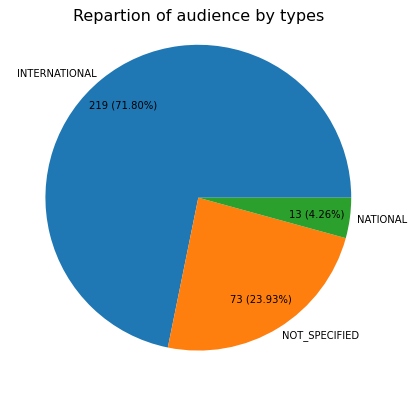

In [23]:
axs = audiences['count'].plot(
    kind='pie',
    subplots=True,
    sharex=False,
    sharey=False,
    #title='Occurence',
    labels=audiences['audience_s'],
    figsize=(6, 6),
    #autopct='%1.1f%%',
    autopct=lambda p: '{total} ({p:.2f}%)'.format(p=p, total=round(p * audiences['count'].sum() / 100)),
    pctdistance=0.78,
    #rotatelabels=False,
    labeldistance=1.05
)
plt.tight_layout()
#plt.figure(1).savefig(occurence_png_target_file)
axs[0].set_ylabel('')
axs[0].set_title('Repartion of audience by types', y=1.0, pad=-14, fontdict={'fontsize': 16})
plt.figure(1).savefig(f'./exports/audience_distribution_pie.png')
plt.show()

## Open Access

In [24]:
def open_access(dataframe,
                title: str,
                filename: str = None,
                params: Dict[str, Any] = dict()):
    
    filename = (filename or '').strip()
    prefix_filename = f'open_access_{filename}' if len(filename) > 0 else 'open_access'
    
    open_access_number_series = dataframe['openAccess_bool'].value_counts().reindex([True, False])
    open_access_number = open_access_number_series.to_frame(name='count').reset_index()
    DfOps(open_access_number).csv(filename=f'{prefix_filename}_distribution.csv', index=False)
    
    default_params = dict(
        kind='pie',
        subplots=True,
        sharex=False,
        sharey=False,
        #title=title,
        ylabel='',
        labels=open_access_number_series.index.tolist(),
        figsize=(6, 6),
        autopct=lambda p: '{total} ({p:.2f}%)'.format(p=p, total=round(p * open_access_number['count'].sum() / 100)),
        pctdistance=0.7,
        fontsize=14,
    )
    open_access_number_png_target_file = f'./exports/{prefix_filename}_distribution.png'
    axs = open_access_number_series.plot(**{**default_params, **params})
    plt.tight_layout()
    axs[0].set_ylabel('')
    axs[0].set_title(
        label = title,
        y = 1.0,
        pad = 6,
        fontdict = {'fontsize': 16},
    )
    plt.figure(1).savefig(open_access_number_png_target_file)
    plt.show()
    LOGGER.info('Saving figure to: "%s"', open_access_number_png_target_file)
    
    return open_access_number

[2023-03-03 14:43:42][INFO ][csv#35] Export to CSV file: ./exports/open_access_all_doc_type_distribution.csv (params: {'index': False}) (number of rows: 2)


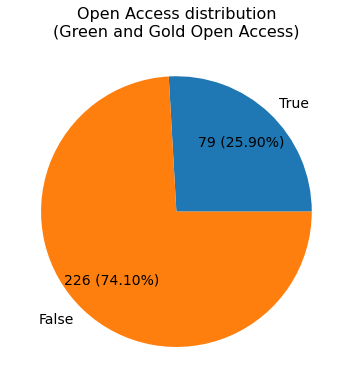

[2023-03-03 14:43:43][INFO ][open_access#38] Saving figure to: "./exports/open_access_all_doc_type_distribution.png"


,index,count
0,True,79
1,False,226


In [25]:
open_access(
    dataframe=df,
    filename='all_doc_type',
    title='Open Access distribution\n(Green and Gold Open Access)',
    params=dict(
        figsize=(5,5),
        pctdistance=0.70,
        labeldistance=1.1
    )
)

# Articles : Data Processing

In [26]:
df_art = df[df['docType_s'] == 'ART'].drop(columns=['docType_s']).reset_index(drop=True)
df_art

,label_s,openAccess_bool,jel_s,keyword_s,authLastName_s,authFirstName_s,authFullName_s,authIdFullName_fs,authIdHal_i,authIdHasPrimaryStructure_fs,...,audience_s,journalTitle_s,journalIssn_s,funding_s,europeanProjectAcronym_s,europeanProjectReference_s,anrProjectTitle_s,anrProjectAcronym_s,anrProjectReference_s,authStructId_i
0,Pierre Januard. Risks on Trade: The Activity o...,False,NaN,NaN,[Januard],[Pierre],[Pierre Januard],[1133802_FacetSep_Pierre Januard],[1133802],[1987654-1133802_FacetSep_Pierre Januard_JoinS...,...,2,History of Economic Ideas,1122-8792,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Laurent Jaffro. Forgiveness and Weak Agency. P...,True,NaN,"[Wager, Forgiveness, Agency, Intertemporal cho...",[Jaffro],[Laurent],[Laurent Jaffro],[238_FacetSep_Laurent Jaffro],[238],[13991-238_FacetSep_Laurent Jaffro_JoinSep_542...,...,2,Proceedings of the Aristotelian Society,0066-7374,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Ariane Dupont-Kieffer. Book review of Economis...,False,NaN,NaN,[Dupont-Kieffer],[Ariane],[Ariane Dupont-Kieffer],[990_FacetSep_Ariane Dupont-Kieffer],[990],[13129-990_FacetSep_Ariane Dupont-Kieffer_Join...,...,2,History of Economic Ideas,1122-8792,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Ariane Dupont Kieffer, Sylvie Rivot, Jean Loup...",True,"[B.B2.B23, B.B3.B31, L.L6, R.R4]","[Golden age, Modèle 4 étapes, Demande routière...","[Dupont Kieffer, Rivot, Madre]","[Ariane, Sylvie, Jean Loup]","[Ariane Dupont Kieffer, Sylvie Rivot, Jean Lou...","[0_FacetSep_Ariane Dupont Kieffer, 0_FacetSep_...",NaN,[2196852-0_FacetSep_Ariane Dupont Kieffer_Join...,...,2,Journal of the History of Economic Thought,1053-8372,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Marie-Laure Massei-Chamayou, Claire Pignol. La...",True,NaN,"[Literature and economics, Commerce, Work, Eli...","[Massei-Chamayou, Pignol]","[Marie-Laure, Claire]","[Marie-Laure Massei-Chamayou, Claire Pignol]","[0_FacetSep_Marie-Laure Massei-Chamayou, 11201...",[1120145],[2367639-0_FacetSep_Marie-Laure Massei-Chamayo...,...,2,XVII-XVIII Revue de la Société d'études anglo-...,2117-590X,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,"Nicholas Sowels, Anémone Kober-Smith, Gilles L...",True,NaN,NaN,"[Sowels, Kober-Smith, Leydier]","[Nicholas, Anémone, Gilles]","[Nicholas Sowels, Anémone Kober-Smith, Gilles ...","[1194204_FacetSep_Nicholas Sowels, 0_FacetSep_...",[1194204],[1036122-1194204_FacetSep_Nicholas Sowels_Join...,...,2,Observatoire de la société britannique,1957-3383,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99,"Aurélien Goutsmedt, Goulven Rubin. Robert J. G...",True,NaN,NaN,"[Goutsmedt, Rubin]","[Aurélien, Goulven]","[Aurélien Goutsmedt, Goulven Rubin]","[16665_FacetSep_Aurélien Goutsmedt, 1120147_Fa...","[16665, 1120147]",[19847-16665_FacetSep_Aurélien Goutsmedt_JoinS...,...,2,History of Economic Ideas,1122-8792,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,"Emmanuelle Benicourt, Sophie Jallais, Camille ...",False,"[A, D, B]","[Economics education, Microeconomics textbooks...","[Benicourt, Jallais, Noûs]","[Emmanuelle, Sophie, Camille]","[Emmanuelle Benicourt, Sophie Jallais, Camille...","[848496_FacetSep_Emmanuelle Benicourt, 9106_Fa...","[848496, 9106, 183511]",[310219-848496_FacetSep_Emmanuelle Benicourt_J...,...,2,Real-World Economics Review,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101,"Claire Pignol, Benoît Walraevens. Book Review:...",False,NaN,NaN,"[Pignol, Walraevens]","[Claire, Benoît]","[Claire Pignol, Benoît Walraevens]","[1120145_FacetSep_Claire Pignol, 172955_FacetS...","[1120145, 172955]",[1263935-1120145_FacetSep_Claire Pignol_JoinSe...,...,2,European Journal of the History of Economic Th...,0967-2567,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Keywords

Count the number of keywords for all articles

In [27]:
keywords = df_art.explode('keyword_s')
keywords = keywords[['keyword_s']].value_counts(dropna=False).to_frame(name='count').reset_index()
keywords.to_csv(path_or_buf='./exports/keywords.csv', index=False)
LOGGER.info('Number of articles without keywords: %d', keywords[keywords.keyword_s.isnull()]["count"].sum())
LOGGER.info('Number of keywords: %d', keywords["keyword_s"].dropna().size)
keywords.head(n=5)

[2023-03-03 14:43:43][INFO ][<module>#4] Number of articles without keywords: 36
[2023-03-03 14:43:43][INFO ][<module>#5] Number of keywords: 359


,keyword_s,count
0,NaN,36
1,Adam Smith,8
2,History of macroeconomics,6
3,Brexit,5
4,Don Patinkin,4


In [28]:
top_count_keywords = keywords.dropna()
top_count_keywords = top_count_keywords[top_count_keywords['count'] >= 2].sort_values(by=['count']).reset_index().sort_values(by=['count'], ascending=False)
top_count_keywords

,index,keyword_s,count
54,1,Adam Smith,8
53,2,History of macroeconomics,6
52,3,Brexit,5
51,4,Don Patinkin,4
47,9,Paul Samuelson,3
44,5,Economics,3
45,6,United Kingdom,3
46,7,Justice,3
48,10,John R Hicks,3
49,11,Économie politique,3


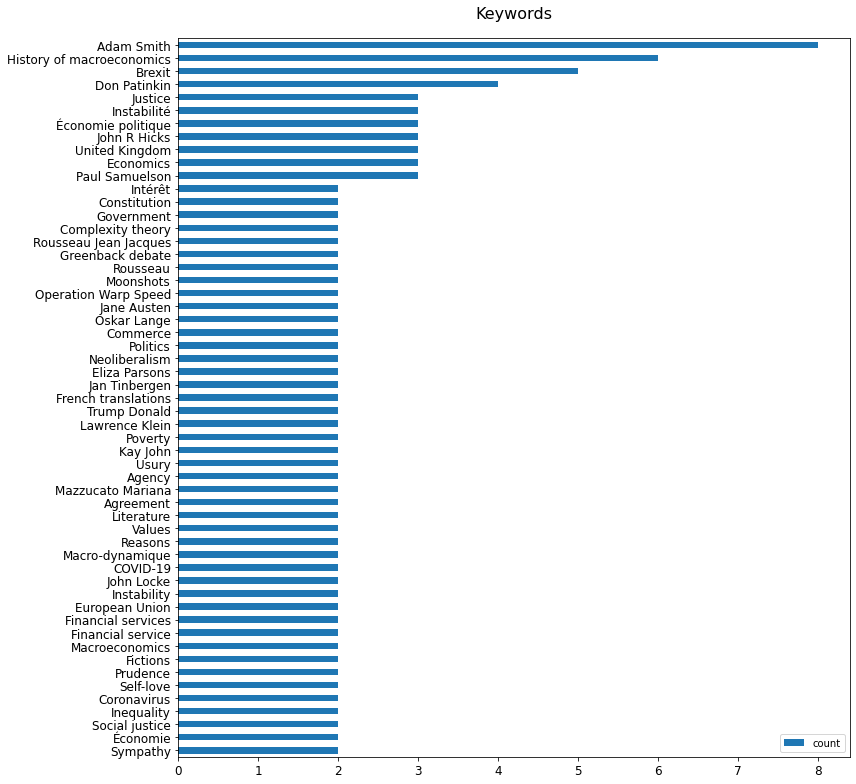

In [29]:
p = top_count_keywords.sort_values(by=['count'], ascending=True).plot(
    kind='barh',
    title='Keywords',
    x='keyword_s',
    y='count',
    xlabel='',
    ylabel='',
    figsize=(12, 11),
    rot=0,
    fontsize=12
)
p.set_title('Keywords', pad=20, fontdict={'fontsize': 16})
plt.tight_layout()
p.get_figure().savefig(f'./exports/keywords_repartition.png')

## Journals

### Journals occurrences 

In [30]:
journals = df_art[['journalTitle_s']].value_counts(dropna=False).to_frame(name='count').reset_index()
journals.to_csv(path_or_buf='./exports/journals.csv', index=False)
LOGGER.info('Number of journals : %d', journals["journalTitle_s"].size)
journals.head(n=5)

[2023-03-03 14:43:43][INFO ][<module>#3] Number of journals : 52


,journalTitle_s,count
0,European Journal of the History of Economic Th...,14
1,History of Political Economy,6
2,Œconomia - History/Methodology/Philosophy,5
3,Revue française de civilisation britannique,5
4,Revue d'histoire de la pensée économique,5


In [31]:
top_count_journals = journals[journals['count'] >= 2].sort_values(by=['count'], ascending=False)
top_count_journals

,journalTitle_s,count
0,European Journal of the History of Economic Th...,14
1,History of Political Economy,6
2,Œconomia - History/Methodology/Philosophy,5
3,Revue française de civilisation britannique,5
4,Revue d'histoire de la pensée économique,5
5,Observatoire de la société britannique,5
6,History of Economic Ideas,4
7,Revue de Métaphysique et de Morale,4
8,Cahiers d'Economie Politique = Papers in polit...,4
9,L'Économie politique,3


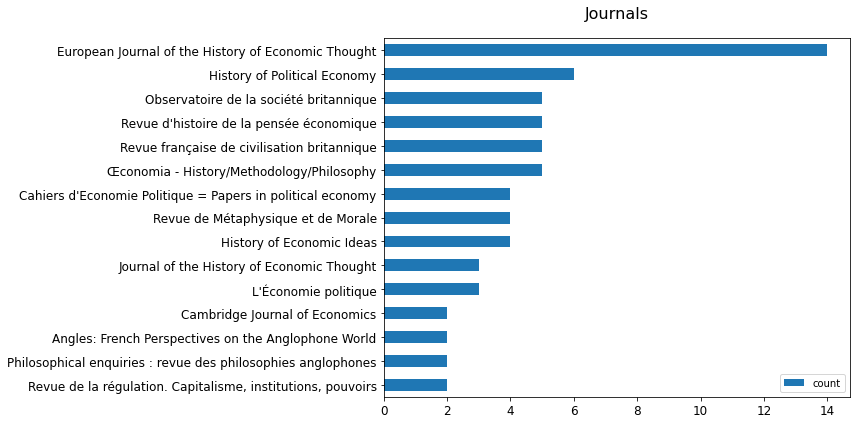

In [32]:
p = top_count_journals.sort_values(by=['count']).plot(
    kind='barh',
    title='Journals',
    x='journalTitle_s',
    y='count',
    xlabel='',
    ylabel='',
    figsize=(12, 6),
    fontsize=12
)
p.set_title('Journals', pad=20, fontdict={'fontsize': 16})
plt.tight_layout()
p.get_figure().savefig(f'./exports/journals_repartition.png')

### Journal without ISSN

In [33]:
journal_without_issns = df_art[df_art.journalIssn_s.isnull()][['uri_s', 'journalTitle_s']].reset_index(drop=True)
journal_without_issns.to_csv(f'./exports/journals_without_issn.csv', index=False)
journal_without_issns

,uri_s,journalTitle_s
0,https://hal.science/hal-03839542,Revue Flaubert
1,https://shs.hal.science/halshs-03985865,La Revue des Lettres modernes. Ecritures XIX
2,https://shs.hal.science/halshs-01960078,Rivista di estetica
3,https://hal-paris1.archives-ouvertes.fr/hal-03...,Real-World Economics Review


## JEL

In [34]:
%%script false --no-raise-error
# Number of Non NA Values
df_art[['uri_s', 'jel_s']].count()

In [35]:
%%script false --no-raise-error
jels = df_art[['uri_s', 'jel_s']].explode('jel_s')
jels.to_csv(path_or_buf='./exports/jels.csv', index=False)
jels = jels.dropna()
jels

In [36]:
%%script false --no-raise-error
jels['jel_s_code'] = jels['jel_s'].apply(lambda x: x.split('.')[0])
count_jels = jels.value_counts(subset=['jel_s_code']).to_frame(name='count').reset_index()
count_jels

In [37]:
%%script false --no-raise-error
p = count_jels.sort_values(by=['count']).plot(
    kind='barh',
    title='JEL',
    x='jel_s_code',
    y='count',
    xlabel='',
    ylabel='',
    figsize=(10, 5),
    fontsize=14,
    rot=0,
)
p.set_title('JEL codes', pad=20, fontdict={'fontsize': 16})
plt.tight_layout()
p.get_figure().savefig(f'./exports/jel_first_level_repartition.png')

## Funding

In [38]:
def funding_stats(dataframe: pd.core.frame.DataFrame,
                  filename: str,
                  columns: List[str],
                  occurence_params: Dict[str, Any] = dict(),
                  occurence_title_params: Dict[str, Any] = dict(),
                  repartition_params: Dict[str, Any] = dict(),
                  repartition_title_params: Dict[str, Any] = dict(),
                  repartition_group_min: int = 0):
    LOGGER.info(f'Start processing funding for output filename "%s" based on columns: %s', filename, columns)
    
    # Extract dataframe data
    exploded = dataframe.explode(columns)
    exploded = exploded[['uri_s'] + columns]
    DfOps(exploded.dropna()).csv(filename=f'fundings_{filename}_uri.csv', index=False)
    
    # Occurences stats
    occurence_exploded = exploded[columns].value_counts(dropna=True).to_frame(name='count').reset_index()
    DfOps(occurence_exploded).csv(filename=f'fundings_{filename}_occurence.csv', index=False)
    if not occurence_exploded.empty:
        occurence_default_params = dict(
            kind='pie',
            subplots=True,
            sharex=False,
            sharey=False,
            title='Occurence',
            ylabel='',
            labels=occurence_exploded[columns[0]],
            figsize=(12, 12),
            autopct='%1.1f%%',
            pctdistance=0.85,
            rotatelabels=True,
            labeldistance=1.02,
        )
        occurence_params = { **occurence_default_params, **occurence_params }
        axs = occurence_exploded['count'].plot(**{ **occurence_params, 'title': None })
        plt.tight_layout()
        axs[0].set_ylabel('')
        axs[0].set_title(**{
            **dict(
                label=occurence_params['title'],
                y=1.0,
                pad=-14,
                fontdict={'fontsize': 16}
            ),
            **occurence_title_params
        })
        occurence_png_target_file = f'./exports/fundings_{filename}_occurence.png' 
        plt.figure(1).savefig(occurence_png_target_file)
        plt.show()
        LOGGER.info('Saving figure to "%s"', occurence_png_target_file)
    else:
        LOGGER.info('Skip figure of occurence for "%s" as the dataframe is empty', filename)
        
    
    # Repartition of having value
    count_exploded = exploded.dropna()[['uri_s']].value_counts().to_frame(name='count').reset_index()
    count_exploded = dataframe.merge(count_exploded, how='left', on='uri_s')
    count_exploded = count_exploded[['uri_s', 'count']].fillna(0).astype({'count': int}).drop_duplicates()
    DfOps(count_exploded).csv(filename=f'fundings_{filename}_count.csv', index=False)
    
    repartition_count_exploded = count_exploded[['count']].value_counts().to_frame(name='number_of_count').reset_index()
    DfOps(repartition_count_exploded).csv(filename=f'fundings_{filename}_repartition.csv', index=False)
    
    if not repartition_count_exploded.empty:
        if repartition_group_min > 0:
            repartition_count_exploded = DfOps(repartition_count_exploded).group_min_values(
                label_column = 'count',
                value_column = 'number_of_count',
                min_value = repartition_group_min,
                min_label = lambda l: str(l)
            )
        repartition_default_params = dict(
            kind='pie',
            subplots=True,
            sharex=False,
            sharey=False,
            title='Repartition',
            ylabel='',
            labels=repartition_count_exploded['count'],
            figsize=(12, 12),
            autopct=lambda p: '{total} ({p:.2f}%)'.format(p=p, total=round(p * repartition_count_exploded['number_of_count'].sum() / 100)),
            pctdistance=0.8,
        )
        repartition_params = {**repartition_default_params, **repartition_params}
        axs = repartition_count_exploded['number_of_count'].plot(**{ **repartition_params, 'title': None })
        repartition_count_exploded_png_target_file = f'./exports/fundings_{filename}_repartition.png'
        plt.tight_layout()
        axs[0].set_ylabel('')
        axs[0].set_title(**{
            **dict(
                label=repartition_params['title'],
                y=1.0,
                pad=-14,
                fontdict={'fontsize': 16}
            ),
            **repartition_title_params
        })
        plt.figure(1).savefig(repartition_count_exploded_png_target_file)
        plt.show()
        LOGGER.info('Saving figure to "%s"', repartition_count_exploded_png_target_file)
    else:
        LOGGER.info('Skip figure of repartition for "%s" as the dataframe is empty', filename)
    
    LOGGER.info('End processing funding for filemane "%s" outputs', filename)


### ANR

[2023-03-03 14:43:44][INFO ][funding_stats#9] Start processing funding for output filename "anr_global" based on columns: ['anrProjectAcronym_s', 'anrProjectReference_s']
[2023-03-03 14:43:44][INFO ][csv#35] Export to CSV file: ./exports/fundings_anr_global_uri.csv (params: {'index': False}) (number of rows: 1)
[2023-03-03 14:43:44][INFO ][csv#35] Export to CSV file: ./exports/fundings_anr_global_occurence.csv (params: {'index': False}) (number of rows: 1)


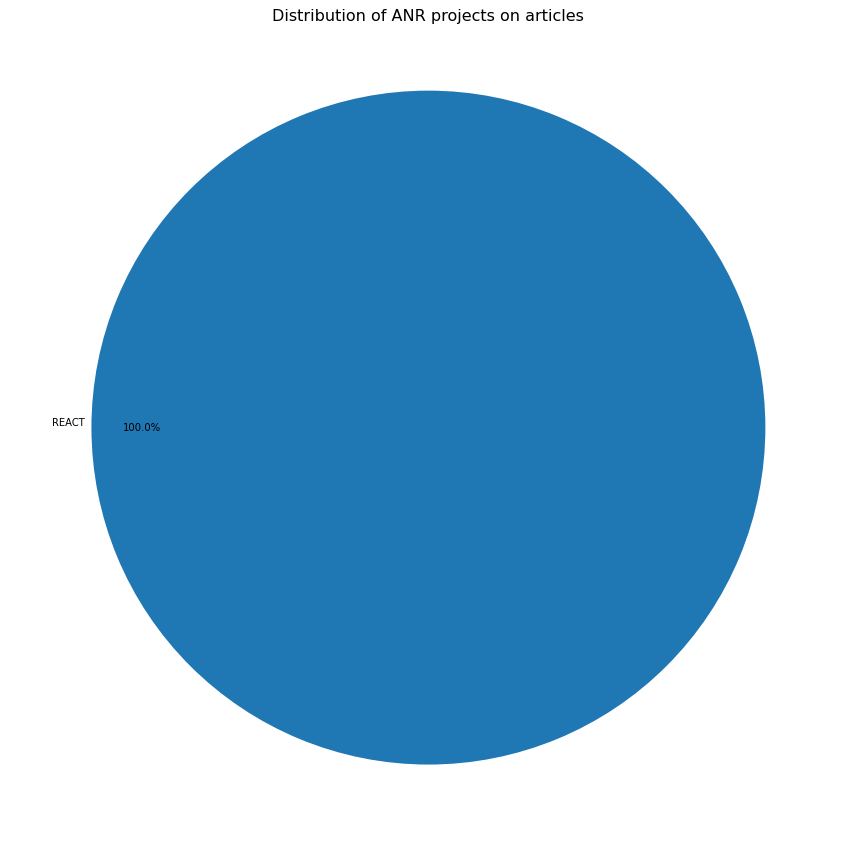

[2023-03-03 14:43:44][INFO ][funding_stats#50] Saving figure to "./exports/fundings_anr_global_occurence.png"
[2023-03-03 14:43:44][INFO ][csv#35] Export to CSV file: ./exports/fundings_anr_global_count.csv (params: {'index': False}) (number of rows: 103)
[2023-03-03 14:43:44][INFO ][csv#35] Export to CSV file: ./exports/fundings_anr_global_repartition.csv (params: {'index': False}) (number of rows: 2)


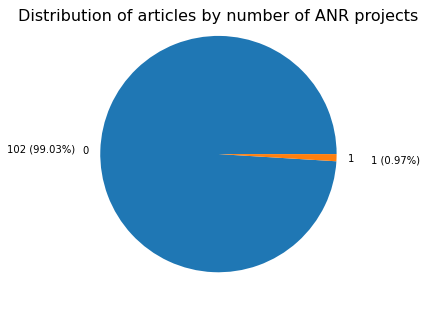

[2023-03-03 14:43:44][INFO ][funding_stats#100] Saving figure to "./exports/fundings_anr_global_repartition.png"
[2023-03-03 14:43:44][INFO ][funding_stats#104] End processing funding for filemane "anr_global" outputs


In [39]:
funding_stats(
    dataframe=df_art,
    columns=['anrProjectAcronym_s', 'anrProjectReference_s'],
    filename='anr_global',
    occurence_params=dict(title='Distribution of ANR projects on articles'),
    repartition_params=dict(title='Distribution of articles by number of ANR projects', figsize=(6,6), pctdistance=1.5),
)

### European

In [40]:
%%script false --no-raise-error
funding_stats(
    dataframe = df_art,
    columns = ['europeanProjectAcronym_s', 'europeanProjectReference_s'],
    filename = 'european_global',
    occurence_params = dict(
        title = 'Distribution of European projects on articles',
        figsize=(8, 8)
    ),
    occurence_title_params = dict(
        pad = 30
    ),
    repartition_params = dict(
        title = 'Distribution of articles by number of European projects',
        figsize = (10, 10),
        pctdistance = 1.5
    ),
)

In [41]:
%%script false --no-raise-error
funding_stats(
    dataframe = df_art,
    columns = ['europeanProjectAcronym_s', 'europeanProjectReference_s'],
    filename = 'european_global_top',
    occurence_params = dict(
        title = 'Distribution of European projects on articles',
        figsize = (8, 8)
    ),
    occurence_title_params = dict(
        pad = 30
    ),
    repartition_params = dict(
        title = 'Distribution of articles\nby number of European projects',
        figsize = (7, 7),
        pctdistance = 1.6
    ),
    repartition_group_min = 6,
)

### Others

In [42]:
%%script false --no-raise-error
other_fundings = df_art.explode(['funding_s'])
other_fundings = other_fundings[['uri_s', 'funding_s']]
other_fundings.dropna().to_csv(path_or_buf='./exports/fundings_other_uri.csv', index=False)
other_fundings = other_fundings[['funding_s']].value_counts(dropna=False).to_frame(name='count').reset_index()
other_fundings.to_csv(path_or_buf='./exports/fundings_other_stats.csv', index=False)
other_fundings.head(n=5)

## Collaborations

### Structure/institution: Country (instStructCountry_s)

An article, may have several `instStructCountry_s`.

We explode the dataset based on the field `instStructCountry_s` to have only one country by row.

In [43]:
collaboration_struct_countries = df_art[['uri_s', 'instStructCountry_s']]
collaboration_struct_countries = collaboration_struct_countries.explode(['instStructCountry_s'])
collaboration_struct_countries

,uri_s,instStructCountry_s
0,https://shs.hal.science/halshs-03515973,fr
1,https://shs.hal.science/halshs-01740553,fr
2,https://hal.archives-ouvertes.fr/hal-03915312,fr
2,https://hal.archives-ouvertes.fr/hal-03915312,fr
3,https://hal.science/hal-03209945,fr
...,...,...
100,https://hal-paris1.archives-ouvertes.fr/hal-03...,fr
101,https://hal-paris1.archives-ouvertes.fr/hal-03...,fr
101,https://hal-paris1.archives-ouvertes.fr/hal-03...,fr
101,https://hal-paris1.archives-ouvertes.fr/hal-03...,fr


In [44]:
collaboration_struct_country_values = collaboration_struct_countries[['instStructCountry_s']].value_counts().to_frame(name='count').reset_index()
collaboration_struct_country_values.to_csv(f'./exports/colloborations_inst_struct_country.csv', index=False)
collaboration_struct_country_values.head(n=5)

,instStructCountry_s,count
0,fr,198
1,tr,4
2,it,1
3,ma,1
4,us,1


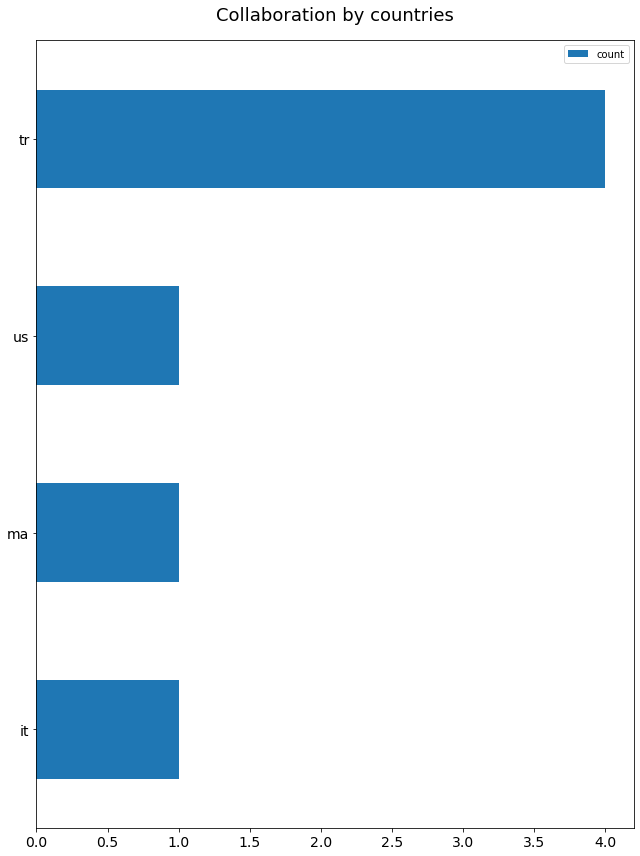

In [45]:
p = collaboration_struct_country_values[(collaboration_struct_country_values.instStructCountry_s != 'fr')].sort_values(by=['count'], ascending=True).plot(
    kind='barh',
    title='Collaboration by countries',
    x='instStructCountry_s',
    y='count',
    xlabel='',
    ylabel='',
    figsize=(9, 12),
    fontsize=14,
    rot=0,
)
p.set_title('Collaboration by countries',pad=20, fontdict={'fontsize':18})
plt.tight_layout()
p.get_figure().savefig(f'./exports/collaboration_struct_country_count.png')

### Structure/institution: Name (instStructName_s)

An article, may have several `instStructName_s`.

We explode the dataset based on the field `instStructName_s` to have only one structure by row.

In [46]:
collaboration_struct_names = df_art[['uri_s', 'instStructName_s']]
collaboration_struct_names = collaboration_struct_names.explode(['instStructName_s'])
collaboration_struct_names

,uri_s,instStructName_s
0,https://shs.hal.science/halshs-03515973,Université Paris 1 Panthéon-Sorbonne
1,https://shs.hal.science/halshs-01740553,Université Paris 1 Panthéon-Sorbonne
2,https://hal.archives-ouvertes.fr/hal-03915312,Université Paris 1 Panthéon-Sorbonne
2,https://hal.archives-ouvertes.fr/hal-03915312,Université Paris 1 Panthéon-Sorbonne
3,https://hal.science/hal-03209945,Université Paris 1 Panthéon-Sorbonne
...,...,...
100,https://hal-paris1.archives-ouvertes.fr/hal-03...,Laboratoire Cogitamus
101,https://hal-paris1.archives-ouvertes.fr/hal-03...,Université Paris 1 Panthéon-Sorbonne
101,https://hal-paris1.archives-ouvertes.fr/hal-03...,Université de Caen Normandie
101,https://hal-paris1.archives-ouvertes.fr/hal-03...,Université de Rennes 1


In [47]:
collaboration_struct_name_aggregation_min = 0
collaboration_struct_name_values = collaboration_struct_names[['instStructName_s']].value_counts().to_frame(name='count').reset_index()
collaboration_struct_name_values.to_csv(f'./exports/colloborations_inst_struct_name.csv', index=False)
collaboration_struct_name_values = collaboration_struct_name_values[(collaboration_struct_name_values.instStructName_s != 'Centre National de la Recherche Scientifique')]
collaboration_struct_name_values = collaboration_struct_name_values[(collaboration_struct_name_values.instStructName_s != 'Université Paris 1 Panthéon-Sorbonne')]
# Retrieve small collaboration to create a new row 'others'
collaboration_struct_name_others = collaboration_struct_name_values[(collaboration_struct_name_values['count'] <= collaboration_struct_name_aggregation_min)]
collaboration_struct_name_others_size = collaboration_struct_name_others['instStructName_s'].size
collaboration_struct_name_others = pd.DataFrame(
    dict(
        instStructName_s=f'Others ({collaboration_struct_name_others_size})',
        count=collaboration_struct_name_others['count'].sum()
    ),
    index=[0]
)
# Cleanup base df for collaboration
collaboration_struct_name_top = collaboration_struct_name_values[(collaboration_struct_name_values['count'] > collaboration_struct_name_aggregation_min)]
collaboration_struct_name_values = pd.concat([collaboration_struct_name_top, collaboration_struct_name_others], ignore_index=True)
collaboration_struct_name_values = collaboration_struct_name_values.sort_values(by=['count'], ascending=False)
collaboration_struct_name_values.to_csv(f'./exports/colloborations_inst_struct_name_filtered_{collaboration_struct_name_aggregation_min}.csv', index=False)
collaboration_struct_name_values.head(n=5)

,instStructName_s,count
0,Université Sorbonne Nouvelle - Paris 3,14
1,Université de Rennes 1,4
2,Middle East Technical University [Ankara],3
3,Université de Reims Champagne-Ardenne,3
4,Université de Caen Normandie,3


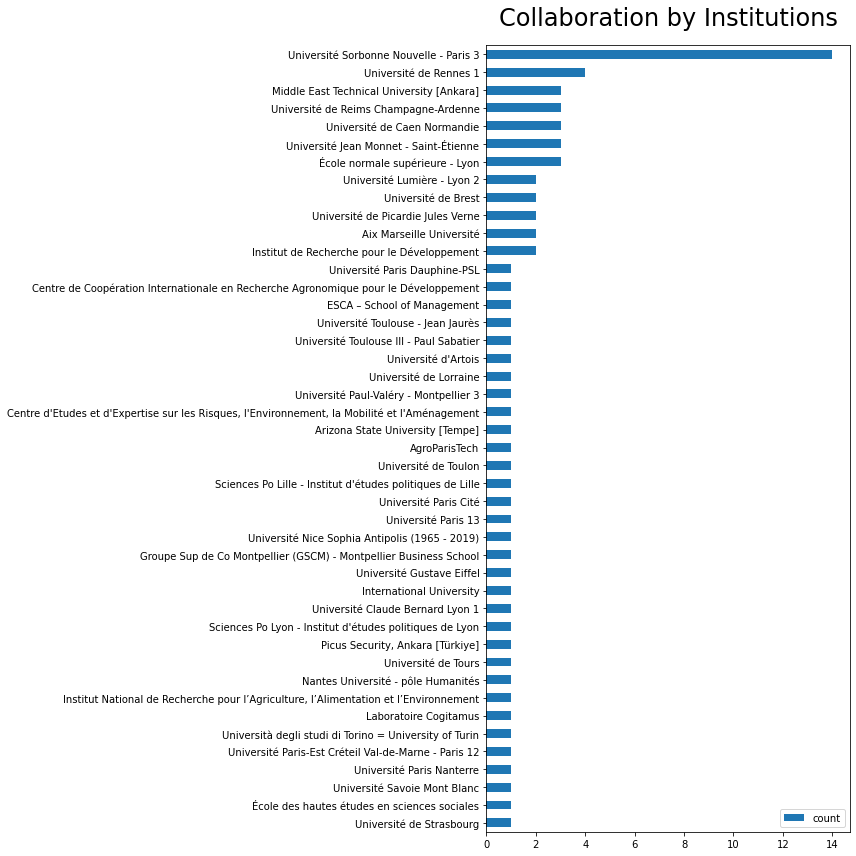

In [48]:
p = collaboration_struct_name_top.sort_values(by=['count']).plot(
    kind='barh',
    title='Collaboration by Institutions',
    x='instStructName_s',
    y='count',
    xlabel='',
    ylabel='',
    figsize=(12, 12)
)
p.set_title('Collaboration by Institutions', pad=20, fontdict={'fontsize':24})
plt.tight_layout()
p.get_figure().savefig(f'./exports/collaboration_struct_name_count_without_others.png')

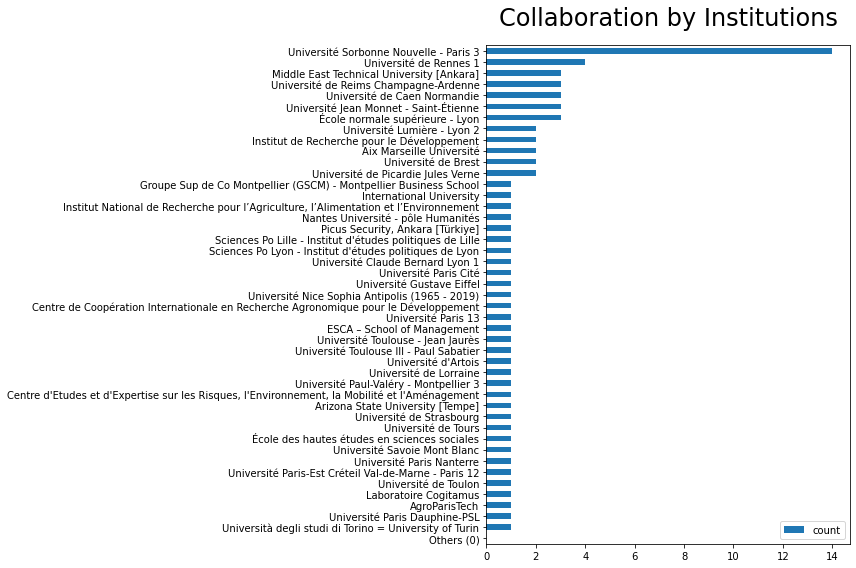

In [49]:
p = collaboration_struct_name_values.sort_values(by=['count']).plot(
    kind='barh',
    title='Collaboration by Institutions',
    x='instStructName_s',
    y='count',
    xlabel='',
    ylabel='',
    figsize=(12, 8)
)
p.set_title('Collaboration by Institutions', pad=20, fontdict={'fontsize':24})
plt.tight_layout()
p.get_figure().savefig(f'./exports/collaboration_struct_name_count.png')

## Full text

Also named attached files ...

An article may have multiple attached files. We will count the number of attached files here by document.

In [50]:
def full_text(dataframe,
              title: str,
              filename: Optional[str] = None,
              params: Dict[str, Any] = dict()):
    
    filename = (filename or '').strip()
    prefix_filename = f'full_text_{filename}' if len(filename) > 0 else 'full_text'
    
    attached_files = dataframe[['uri_s', 'files_s']].copy()
    attached_files['attached_files_count'] = attached_files['files_s'].apply(lambda x: len(x) if pd.notnull(x) else 0)
    DfOps(attached_files[['uri_s', 'attached_files_count']]).csv(filename=f'{prefix_filename}.csv', index=False)
     
    attached_files_number = attached_files['attached_files_count'].value_counts().sort_index()
    DfOps(attached_files_number).csv(filename=f'{prefix_filename}_distribution.csv', index=False)
    
    default_params = dict(   
        kind='pie',
        subplots=True,
        sharex=False,
        sharey=False,
        #title=title,
        ylabel='',
        labels=attached_files_number.index.tolist(),
        figsize=(6, 6),
        autopct=lambda p: '{total} ({p:.2f}%)'.format(p=p, total=round(p * attached_files_number.sum() / 100)),
        pctdistance=0.7,
        fontsize=14,
    )
    attached_files_number_png_target_file = f'./exports/{prefix_filename}_distribution.png'
    axs = attached_files_number.plot(**{**default_params, **params})
    plt.tight_layout()
    axs[0].set_ylabel('')
    axs[0].set_title(
        label = title,
        y = 1.0,
        pad = 6,
        fontdict = {'fontsize': 16},
    )
    plt.figure(1).savefig(attached_files_number_png_target_file)
    plt.show()
    LOGGER.info('Saving figure to : "%s"', attached_files_number_png_target_file)
    return attached_files 

[2023-03-03 14:43:45][INFO ][csv#35] Export to CSV file: ./exports/full_text.csv (params: {'index': False}) (number of rows: 103)
[2023-03-03 14:43:45][INFO ][csv#35] Export to CSV file: ./exports/full_text_distribution.csv (params: {'index': False}) (number of rows: 2)


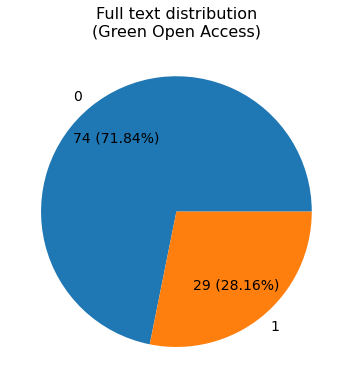

[2023-03-03 14:43:45][INFO ][full_text#41] Saving figure to : "./exports/full_text_distribution.png"


,uri_s,files_s,attached_files_count
0,https://shs.hal.science/halshs-03515973,NaN,0
1,https://shs.hal.science/halshs-01740553,NaN,0
2,https://hal.archives-ouvertes.fr/hal-03915312,NaN,0
3,https://hal.science/hal-03209945,[https://hal.science/hal-03209945/file/doc0003...,1
4,https://hal-paris1.archives-ouvertes.fr/hal-03...,NaN,0
...,...,...,...
98,https://hal.science/hal-03933394,[https://hal.science/hal-03933394/file/2017-Ac...,1
99,https://hal.science/hal-02988080,[https://hal.science/hal-02988080/file/gordon-...,1
100,https://hal-paris1.archives-ouvertes.fr/hal-03...,NaN,0
101,https://hal-paris1.archives-ouvertes.fr/hal-03...,NaN,0


In [51]:
full_text(
    dataframe=df_art,
    title='Full text distribution\n(Green Open Access)',
    params=dict(
        figsize=(5,5),
        pctdistance=0.70,
        labeldistance=1.1
    )
)

## Open Access

[2023-03-03 14:43:45][INFO ][csv#35] Export to CSV file: ./exports/open_access_on_articles_distribution.csv (params: {'index': False}) (number of rows: 2)


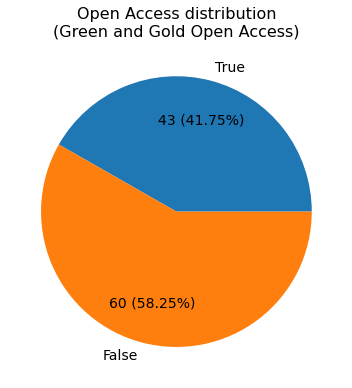

[2023-03-03 14:43:45][INFO ][open_access#38] Saving figure to: "./exports/open_access_on_articles_distribution.png"


,index,count
0,True,43
1,False,60


In [52]:
open_access(
    dataframe=df_art,
    filename='on_articles',
    title='Open Access distribution\n(Green and Gold Open Access)',
    params=dict(
        figsize=(5,5),
        pctdistance=0.70,
        labeldistance=1.1
    )
)

## Ranking



In [53]:
def create_ranking_journals_df(dataframe: pd.core.frame.DataFrame,
                               filename_prefix: Optional[str] = None,
                               excludes: Optional[List[str]] = None):
    excludes = excludes or []
    includes = [i for i in ['ECONLIT', 'MATHSCINET', 'SCIMAGO', 'HCERES', 'CNRS_S37'] if i not in excludes]
    LOGGER.info('Create ranking dataframe including: %s (excludes=%s)', includes, excludes)
    
    
    ranking_journals = dataframe[['uri_s', 'journalTitle_s', 'journalIssn_s']].copy()
    ranking_journals['ISSN'] = ranking_journals['journalIssn_s']
    # Econlit
    if 'ECONLIT' in includes:
        ranking_journals = ranking_journals.merge(econlit_df, how='left', on='ISSN', validate='many_to_one')
        ranking_journals['ECONLIT'] = ranking_journals['Title'].notnull()
        ranking_journals = ranking_journals.drop(columns=['Title'])
    
    # MathSciNet
    if 'MATHSCINET' in includes:
        ranking_journals = ranking_journals.merge(mathscinet_df, how='left', on='ISSN', validate='many_to_one')
        ranking_journals['MATHSCINET'] = ranking_journals['Title'].notnull()
        ranking_journals = ranking_journals.drop(columns=['Title'])
    
    # Scimago
    if 'SCIMAGO' in includes:
        ranking_journals = ranking_journals.merge(scimagojr_df, how='left', on='ISSN', validate='many_to_one')
        ranking_journals['SCIMAGO'] = ranking_journals['Title'].notnull()
        ranking_journals = ranking_journals.drop(columns=['Title']).rename(columns={'CATEGORIES': 'SCIMAGO_CATEGORIES'})
    
    # HCERES
    if 'HCERES' in includes:
        ranking_journals = ranking_journals.merge(hceres_df, how='left', on='ISSN', validate='many_to_one')
        ranking_journals = ranking_journals.drop(columns=['Title'])
        ranking_journals['HCERES'] = ranking_journals['HCERES_2021'].notnull()
        ranking_journals = ranking_journals.rename(columns={'HCERES_2021': 'HCERES_RANK', 'CoNRS_2020': 'HCERES_CONRS_RANK', 'FNEGE_2019': 'HCERES_FNEGE_RANK'})
    
    # CNRS_S37
    if 'CNRS_S37' in includes:
        ranking_journals = ranking_journals.merge(cnrs_s37_df, how='left', on='ISSN', validate='many_to_one')
        ranking_journals = ranking_journals.drop(columns=['Title'])
        ranking_journals['CNRS_S37'] = ranking_journals['domaine'].notnull()
        ranking_journals = ranking_journals.rename(columns={'domaine': 'CNRS_S37_DOMAINE', 'cat': 'CNRS_S37_CAT'})
        
    
    # HCERES + Scimago + MathSciNet + Econlit + CNRS s37 (if includes)
    ranking_journals['NUMBER_OF_REFERENTIALS'] = ranking_journals[includes].apply(lambda x: x.sum(), axis=1, raw=True)
    
    # Cleanup data
    ranking_journals = ranking_journals.drop(columns=['ISSN'])
    if filename_prefix:
        DfOps(ranking_journals).csv(filename=f'{filename_prefix}.csv', index=False)
    
    return ranking_journals

In [54]:
def journals_ranking_plot(dataframe: pd.core.frame.DataFrame,
                          titles: Dict[str, str] = dict(),
                          filename_prefix: str = 'rankings'):
    titles = titles or {}
    possible_columns = ['MATHSCINET', 'SCIMAGO', 'ECONLIT', 'HCERES', 'CNRS_S37']
    columns = [i for i in possible_columns if i in dataframe]
    
    if not columns:
        LOGGER.warning('Cannot plot journals ranking as there is no columns in: %s', possible_columns)
        return
    
    target_file_filtered = f'./exports/{filename_prefix}_filtered.csv'
    DfOps(dataframe[['uri_s'] + columns]).csv(filename=f'{filename_prefix}_filtered.csv', index=False)
    
    ranking_aggregation_transposed = dataframe[columns].apply(pd.Series.value_counts).transpose().fillna(0)
    DfOps(ranking_aggregation_transposed).csv(filename=f'{filename_prefix}_count.csv', index=False)

    true_values = ranking_aggregation_transposed[True].tolist()
    true_labels = round(100 * ranking_aggregation_transposed[True] / ranking_aggregation_transposed.sum(axis='columns'), 1)
    true_labels = ranking_aggregation_transposed[True].combine(true_labels, func=lambda v, p: f'{v} ({p}%)').tolist()

    false_values = ranking_aggregation_transposed[False].tolist()
    false_labels = round(100 * ranking_aggregation_transposed[False] / ranking_aggregation_transposed.sum(axis='columns'), 1)
    false_labels = ranking_aggregation_transposed[False].combine(false_labels, func=lambda v, p: f'{v} ({p}%)').tolist()

    ind = np.arange(len(true_values)) 
    width = 0.60

    fig, ax = plt.subplots(figsize=(12,6))

    true_plot = ax.barh(columns, true_values, width, label='True', linewidth=0 )
    false_plot = ax.barh(columns, false_values, width, left=true_values, label='False', linewidth=0)

    title = 'Articles ranking'
    LOGGER.debug('Retrieve title using key: %s (default: %s)', title, title)
    title = titles.get('Articles ranking', 'Articles ranking')
    ax.set_title(title, pad=10, fontsize=18)
    ax.set_xlabel('Articles', fontsize=13)
    ax.bar_label(true_plot, label_type='center', fontsize=13, labels=true_labels)
    ax.bar_label(false_plot, label_type='center', fontsize=13, labels=false_labels)
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=13)
    fig.tight_layout()
    target_file_general = f'./exports/{filename_prefix}_general.png'
    fig.savefig(target_file_general)
    LOGGER.info('Saved figure at "%s"', target_file_general)
    plt.show()

In [55]:
def cnrs_s37_ranking_plot(dataframe: pd.core.frame.DataFrame,
                        titles: Dict[str, str] = dict(),
                        filename_prefix: str = 'rankings',
                        params:Dict[str, Any] = dict()):
    if 'CNRS_S37_CAT' not in dataframe:
        LOGGER.warning('Skip plotting CNRS_S37 as "CNRS_S37_CAT" is not a column of the DataFrame')
        return
    
    titles = titles or {}
    title = 'CNRS S37 articles ranking'
    LOGGER.debug('Retrieve title using key: %s (default=%s)', title, title) 
    title = titles.get(title, title)
    
    LOGGER.info('Create ranking plot "%s" for CNRS (params=%s)', title, params)
    cnrs_s37_rankings = dataframe['CNRS_S37_CAT'].dropna().value_counts().to_frame(name='count').reset_index().rename(columns={'index': 'cat'})
    DfOps(cnrs_s37_rankings, prefix=filename_prefix) \
        .csv(filename=f'{filename_prefix}_cnrs_s37.csv', index=False) \
        .pie(
            label_column = 'cat',
            column = 'count', 
            title = title,
            sort_by = ['cat'],
            plot_params = {**dict(figsize=(6, 6)), **params},
        #    title_params: Dict[str, Any] = None,
        #    sort_params: Dict[str, Any] = None,
        )


In [56]:
def hceres_ranking_plot(dataframe: pd.core.frame.DataFrame,
                        titles: Dict[str, str] = dict(),
                        filename_prefix: str = 'rankings',
                        params:Dict[str, Any] = dict()):
    if 'HCERES_RANK' not in dataframe:
        LOGGER.warning('Skip plotting HCERES as "HCERES_RANK" is not a column of the DataFrame')
        return
    
    titles = titles or {}
    title = 'HCERES articles ranking'
    LOGGER.debug('Retrieve title using key: %s (default=%s)', title, title) 
    title = titles.get(title, title)
    
    LOGGER.info('Create ranking plot "%s" for HCERES (params=%s)', title, params)
    hceres_rankings = dataframe['HCERES_RANK'].dropna().value_counts().sort_index()
    DfOps(hceres_rankings.to_frame(name='count_hceres_ranks')).csv(filename=f'{filename_prefix}_hceres.csv', index=False)
    default_params = dict(
        kind='pie',
        subplots=True,
        sharex=False,
        sharey=False,
        ylabel='',
        labels=hceres_rankings.index.tolist(),
        figsize=(6, 6),
        autopct=lambda p: '{total} ({p:.2f}%)'.format(p=p, total=round(p * hceres_rankings.sum() / 100)),
        pctdistance=0.6,
        fontsize=14,
    )
    hceres_rankings.plot(**{**default_params, **params})
   
    plt.figure(1).axes[0].set_title(title, pad=0, fontdict={'fontsize':15})
    plt.tight_layout()
    target_file_png = f'./exports/{filename_prefix}_hceres.png'
    plt.figure(1).savefig(target_file_png)
    LOGGER.info('Saved figure at "%s"', target_file_png)
    plt.show()

In [57]:
def create_scimajo_df(dataframe: pd.core.frame.DataFrame,
                      filename_prefix: str = 'rankings',
                      suffix: int = 0,
                      quantile: float = 0.0) -> pd.core.frame.DataFrame:
    
    if 'SCIMAGO_CATEGORIES' not in dataframe:
        LOGGER.warning('Cannot create scimajo dataframe as "SCIMAGO_CATEGORIES" column doesn\'t exist')
        return pd.DataFrame()
    
    scimagojr_categories = dataframe[['uri_s', 'journalTitle_s', 'SCIMAGO_CATEGORIES']].copy().dropna()
    scimagojr_categories['CATEGORY'] = scimagojr_categories['SCIMAGO_CATEGORIES'].str.split(';')
    scimagojr_categories = scimagojr_categories.explode('CATEGORY')
    scimagojr_categories['CATEGORY'] = scimagojr_categories['CATEGORY'].str.strip()
    scimagojr_categories['SCIMAGO_JOURNAL_RANKING'] = scimagojr_categories['CATEGORY'].str.extract('^.*\((?P<sjr>Q[1-4])\)\s*$')
    scimagojr_categories['CATEGORY_WITHOUT_SJR'] = scimagojr_categories['CATEGORY'].str.extract('^(?P<cat>.*)\s+\(Q[1-4]\)\s*$')
    scimagojr_categories = scimagojr_categories.reset_index(drop=True)
    target_file = f'./exports/{filename_prefix}_scimago.csv'
    scimagojr_categories.to_csv(target_file, index=False)
    LOGGER.info('Saved CSV at "%s"', target_file)
    
    # Add a category others when we have to small values
    if quantile > 0:
        LOGGER.info('Rework dataframe to group the less used categories (quantile=%f)', quantile)
        scimagojr_category_names = scimagojr_categories['CATEGORY_WITHOUT_SJR'].value_counts()
        bottom_value = scimagojr_category_names.quantile(q=quantile)
        less_freq_scimagojr_category_names = scimagojr_category_names[scimagojr_category_names <= bottom_value]
        scimagojr_categories.loc[scimagojr_categories['CATEGORY_WITHOUT_SJR'].isin(less_freq_scimagojr_category_names.index.tolist())] = "Others"
    
    target_file_filtered = f'./exports/{filename_prefix}_scimago_filtered_{suffix}.csv'
    scimagojr_categories.to_csv(target_file_filtered, index=False)
    LOGGER.info('Saved CSV at "%s', target_file_filtered)
    
    # Create a new column with category with percent (for the occurence of this category)
    scimagojr_category_names = scimagojr_categories['CATEGORY_WITHOUT_SJR'].value_counts().to_frame().reset_index()
    scimagojr_category_names = scimagojr_category_names.rename(columns={'index': 'CATEGORY_WITHOUT_SJR', 'CATEGORY_WITHOUT_SJR': 'CATEGORY_WITHOUT_SJR_COUNT'})
    scimagojr_category_names['CATEGORY_WITHOUT_JSR_PERCENT'] = scimagojr_category_names.apply(
        lambda row: '{n} - {v} ({p}%)'.format(
            n = row['CATEGORY_WITHOUT_SJR'],
            v = row['CATEGORY_WITHOUT_SJR_COUNT'],
            p = round(100 * row['CATEGORY_WITHOUT_SJR_COUNT'] / scimagojr_category_names['CATEGORY_WITHOUT_SJR_COUNT'].sum(), 1)
        ),
        axis='columns'
    )

    # Merge with initial dataframe
    scimagojr_categories = scimagojr_categories.merge(scimagojr_category_names, how='inner', on=['CATEGORY_WITHOUT_SJR'])
    
    return scimagojr_categories

In [58]:
def scimago_ranking_plot(dataframe: pd.core.frame.DataFrame,
                         titles: Dict[str, str] = dict(),
                         filename_prefix: str = 'rankings',
                         suffix: int = 0,
                         category_params:Dict[str, Any] = dict()):
    if 'CATEGORY_WITHOUT_JSR_PERCENT' not in dataframe:
        LOGGER.warning('Skip plotting Scimago as "CATEGORY_WITHOUT_JSR_PERCENT" is not a column of the DataFrame')
    
    titles = titles or {}
    
    # Fig 1 : Category
    scimago_category_names = dataframe['CATEGORY_WITHOUT_JSR_PERCENT'].value_counts()
    default_category_params = dict(
        kind='pie',
        subplots=True,
        sharex=False,
        sharey=False,
        ylabel='',
        labels=scimago_category_names.index.tolist(),
        figsize=(18, 12),
        autopct=lambda p: '{total} ({p:.2f}%)'.format(p=p, total=round(p * scimago_category_names.sum() / 100)),
        pctdistance=0.9,
        labeldistance=None,
        legend=True
    )
    
    title_categories = 'Scimago JCR: categories'
    LOGGER.debug('Retrieve title using key: %s (default=%s)', title_categories, title_categories)
    title_categories = titles.get(title_categories, title_categories)
    target_file_categories = f'./exports/{filename_prefix}_scimago_categories_{suffix}.png'
    
    scimago_category_names.plot(**{**default_category_params, **category_params})
    plt.legend(loc='best', bbox_to_anchor=(0.1, 0.9))
    plt.figure(1).axes[0].set_title(title_categories, pad=0, fontdict={'fontsize':15})
    plt.tight_layout()
    
    plt.figure(1).savefig(target_file_categories)
    LOGGER.info('Saved figure at "%s"', target_file_categories)
    plt.show()
    
    # Fig 2 : SJR Repartition
    scimajo_journal_rankings = dataframe['SCIMAGO_JOURNAL_RANKING'].value_counts()
    scimajo_journal_rankings.plot(
        kind='pie',
        subplots=True,
        sharex=False,
        sharey=False,
        ylabel='',
        labels=scimajo_journal_rankings.index.tolist(),
        figsize=(6, 6),
        autopct=lambda p: '{total} ({p:.2f}%)'.format(p=p, total=round(p * scimajo_journal_rankings.sum() / 100)),
        pctdistance=0.7,
        labeldistance=1.1,
    )
    
    title_quartiles = 'Scimago JCR: quartiles'
    LOGGER.debug('Retrieve title using key: %s (default=%s)', title_quartiles, title_quartiles)
    title_quartiles = titles.get(title_quartiles, title_quartiles)
    target_file_quartiles = f'./exports/{filename_prefix}_scimago_sjr_q_score_{suffix}.png'
    
    plt.figure(1).axes[0].set_title(title_quartiles, pad=0, fontdict={'fontsize':15})
    plt.tight_layout()
    plt.figure(1).savefig(target_file_quartiles)
    LOGGER.info('Saved figure at "%s"', target_file_quartiles)
    plt.show()

In [59]:
def cross_referentials_plot(dataframe: pd.core.frame.DataFrame,
                            titles: Dict[str, str] = dict(),
                            filename_prefix: str = 'rankings'):
    
    titles = titles or {}
    title = 'Distribution of articles'
    LOGGER.debug('Retrieve title using key: %s (default=%s)', title, title)
    title = titles.get(title, title)
    target_file = f'./exports/{filename_prefix}_distribution_of_articles_in_journal_classification_referentials.png'
    
    cross_ref_s = dataframe['NUMBER_OF_REFERENTIALS'].value_counts().sort_index()
    cross_ref_s.plot(
        kind='pie',
        subplots=True,
        sharex=False,
        sharey=False,
        ylabel='',
        labels=cross_ref_s.index.tolist(),
        figsize=(6, 6),
        autopct=lambda p: '{total} ({p:.2f}%)'.format(p=p, total=round(p * cross_ref_s.sum() / 100)),
        pctdistance=0.7,
        labeldistance=1.1,
    )
    plt.figure(1).axes[0].set_title(title, pad=0, fontdict={'fontsize':15})
    plt.tight_layout()
    plt.figure(1).savefig(target_file)
    LOGGER.info('Saved figure at "%s"', target_file)
    plt.show()

In [60]:
def scimago_hceres_matrix(dataframe: pd.core.frame.DataFrame,
                          filename_prefix: str = 'rankings') -> pd.core.frame.DataFrame:
    if 'HCERES_RANK' not in dataframe or 'SJR_BEST_QUARTILE' not in dataframe:
        LOGGER.warning('Cannot create a matrix for HCERES*Scimago Best Quartile as current dataframe doesn\'t have the columns')
        return pd.DataFrame()

    target_base_file = f'./exports/{filename_prefix}_hceres_scimago_matrix'
    LOGGER.info('Create Scimago / HCERES matrix')
    ranking_scimago_hceres_df = dataframe[['HCERES_RANK', 'SJR_BEST_QUARTILE']].fillna('NON REFERENCE')
    ranking_scimago_hceres_df = ranking_scimago_hceres_df.value_counts(dropna=False)
    
    ranking_scimago_hceres_df.to_excel(f'{target_base_file}.xlsx')
    LOGGER.info('Saved Excel at "%s.xlsx"', target_base_file)
    
    ranking_scimago_hceres_df = ranking_scimago_hceres_df.unstack(fill_value=0)
    ranking_scimago_hceres_df.to_excel(f'{target_base_file}_2.xlsx')
    LOGGER.info('Saved Excel at "%s_2.xlsx"', target_base_file)
    return ranking_scimago_hceres_df

In [61]:
def rankings(dataframe: pd.core.frame.DataFrame,
             titles: Dict[str, str] = dict(),
             excludes: List[str] = [],
             filename_prefix: str = 'rankings',
             hceres_category_params: Dict[str, Any] = dict(),
             cnrs_s37_category_params: Dict[str, Any] = dict(),):
    LOGGER.info('Process ranking (filename_prefix=%s, titles=%s)', filename_prefix, titles)
    rankings_journals = create_ranking_journals_df(
        dataframe = dataframe,
        excludes = excludes,
        filename_prefix = filename_prefix
    )
    journals_ranking_plot(
        dataframe = rankings_journals,
        titles = titles,
        filename_prefix = filename_prefix
    )
    hceres_ranking_plot(
        dataframe = rankings_journals,
        titles = titles,
        filename_prefix = filename_prefix,
        params = hceres_category_params
    )
    cnrs_s37_ranking_plot(
        dataframe = rankings_journals,
        titles = titles,
        filename_prefix = filename_prefix,
        params = cnrs_s37_category_params
    )
    cross_referentials_plot(
        dataframe = rankings_journals,
        titles = titles,
        filename_prefix = filename_prefix
    )
    return rankings_journals

In [62]:
def scimago_rankings(dataframe: pd.core.frame.DataFrame,
                     titles: Dict[str, str] = dict(),
                     filename_prefix: str = 'rankings',
                     suffix: int = 0,
                     quantile: float = 0.0,
                     category_params: Dict[str, Any] = dict()):
    # The input dataframe should be a return of create_ranking_journals_df or rankings
    LOGGER.info('Process scimago rankings (filename_prefix=%s, titles=%s)', filename_prefix, titles) 
    scimajo_df = create_scimajo_df(
        dataframe=dataframe,
        filename_prefix=filename_prefix,
        suffix=suffix,
        quantile=quantile
    )
    scimago_ranking_plot(
        dataframe=scimajo_df,
        titles=titles,
        filename_prefix=filename_prefix,
        suffix=suffix,
        category_params=category_params
    )

### Using all ranking systems

[2023-03-03 14:43:45][INFO ][rankings#7] Process ranking (filename_prefix=rankings_all, titles={'Articles ranking': 'Distribution of articles\nby journal rating reference system', 'HCERES articles ranking': 'Distribution of articles\nfor the HCERES Vague B 2021 rating reference system', 'Distribution of articles': 'Distribution of articles\nin journal rating reference systems'})
[2023-03-03 14:43:45][INFO ][create_ranking_journals_df#6] Create ranking dataframe including: ['ECONLIT', 'MATHSCINET', 'SCIMAGO', 'HCERES', 'CNRS_S37'] (excludes=[])
[2023-03-03 14:43:45][INFO ][csv#35] Export to CSV file: ./exports/rankings_all.csv (params: {'index': False}) (number of rows: 103)
[2023-03-03 14:43:45][INFO ][csv#35] Export to CSV file: ./exports/rankings_all_filtered.csv (params: {'index': False}) (number of rows: 103)
[2023-03-03 14:43:45][INFO ][csv#35] Export to CSV file: ./exports/rankings_all_count.csv (params: {'index': False}) (number of rows: 5)
[2023-03-03 14:43:46][INFO ][journals_

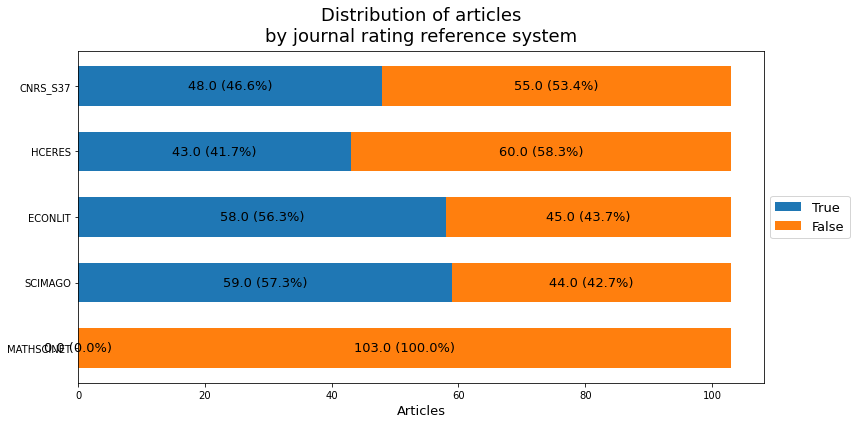

[2023-03-03 14:43:46][INFO ][hceres_ranking_plot#14] Create ranking plot "Distribution of articles
for the HCERES Vague B 2021 rating reference system" for HCERES (params={})
[2023-03-03 14:43:46][INFO ][csv#35] Export to CSV file: ./exports/rankings_all_hceres.csv (params: {'index': False}) (number of rows: 3)
[2023-03-03 14:43:46][INFO ][hceres_ranking_plot#35] Saved figure at "./exports/rankings_all_hceres.png"


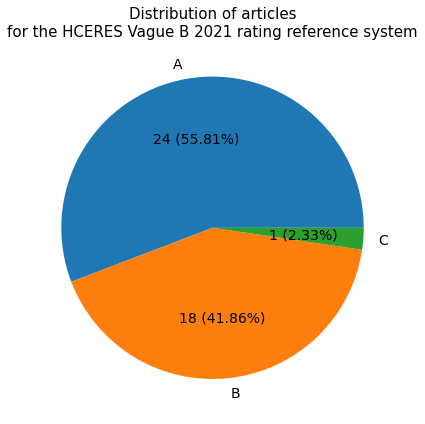

[2023-03-03 14:43:46][INFO ][cnrs_s37_ranking_plot#14] Create ranking plot "CNRS S37 articles ranking" for CNRS (params={})
[2023-03-03 14:43:46][INFO ][csv#35] Export to CSV file: ./exports/rankings_all_rankings_all_cnrs_s37.csv (params: {'index': False}) (number of rows: 4)
[2023-03-03 14:43:46][INFO ][pie#127] Export pie graph to PNG file: ./exports/rankings_all_cnrs_s37_articles_ranking.png


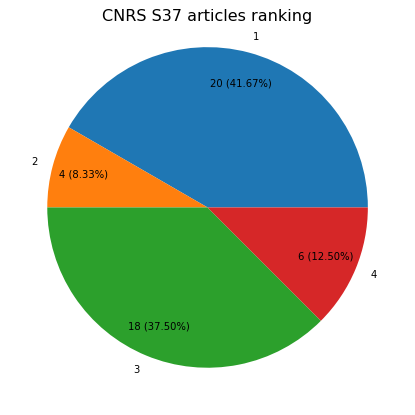

[2023-03-03 14:43:46][INFO ][cross_referentials_plot#27] Saved figure at "./exports/rankings_all_distribution_of_articles_in_journal_classification_referentials.png"


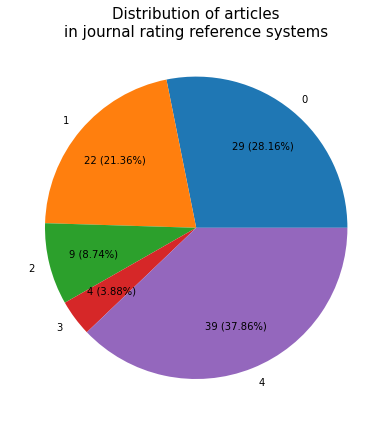

[2023-03-03 14:43:46][INFO ][scimago_hceres_matrix#8] Create Scimago / HCERES matrix
[2023-03-03 14:43:46][INFO ][scimago_hceres_matrix#13] Saved Excel at "./exports/rankings_all_hceres_scimago_matrix.xlsx"
[2023-03-03 14:43:46][INFO ][scimago_hceres_matrix#17] Saved Excel at "./exports/rankings_all_hceres_scimago_matrix_2.xlsx"
[2023-03-03 14:43:46][INFO ][scimago_rankings#8] Process scimago rankings (filename_prefix=rankings_all, titles={'Scimago JCR: categories': 'Distribution of articles by category\nfor the Scimago JCR rating reference system', 'Scimago JCR: quartiles': 'Distribution of articles by quartiles\nfor the Scimago JCR rating reference system'})
[2023-03-03 14:43:46][INFO ][create_scimajo_df#19] Saved CSV at "./exports/rankings_all_scimago.csv"
[2023-03-03 14:43:46][INFO ][create_scimajo_df#31] Saved CSV at "./exports/rankings_all_scimago_filtered_0.csv
[2023-03-03 14:43:46][INFO ][scimago_ranking_plot#38] Saved figure at "./exports/rankings_all_scimago_categories_0.png"

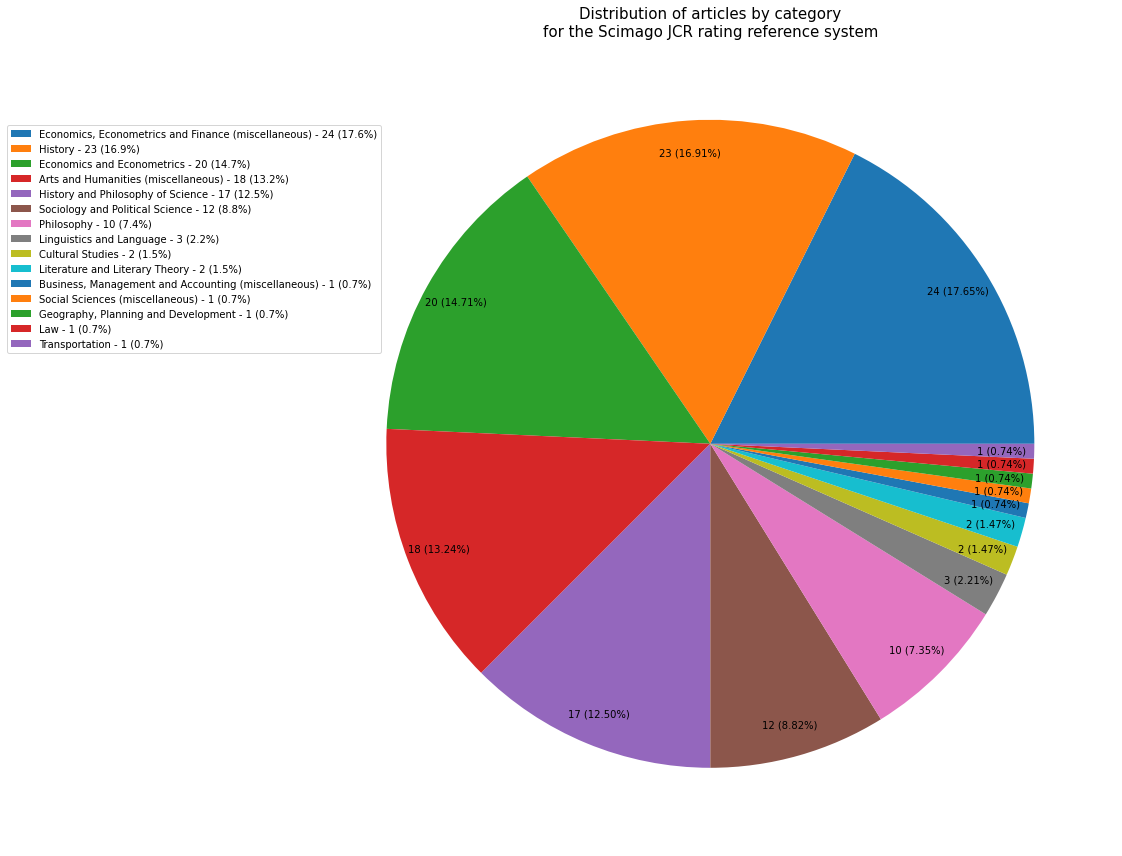

[2023-03-03 14:43:47][INFO ][scimago_ranking_plot#64] Saved figure at "./exports/rankings_all_scimago_sjr_q_score_0.png"


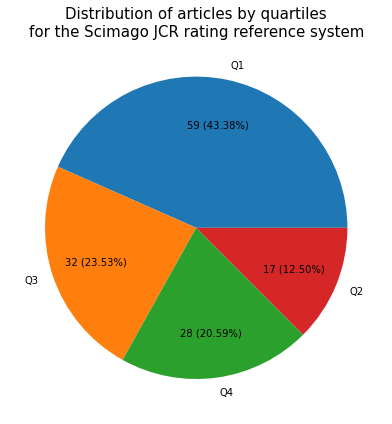

,uri_s,journalTitle_s,journalIssn_s,URL,ECONLIT,MATHSCINET,SCIMAGO_CATEGORIES,SJR_BEST_QUARTILE,SCIMAGO,HCERES_CONRS_RANK,HCERES_FNEGE_RANK,HCERES_RANK,HCERES,CNRS_S37_DOMAINE,CNRS_S37_CAT,CNRS_S37,NUMBER_OF_REFERENTIALS
0,https://shs.hal.science/halshs-03515973,History of Economic Ideas,1122-8792,http://www.libraweb.net/sommari.php?chiave=61,True,False,History (Q1); Economics and Econometrics (Q3);...,Q1,True,3,NaN,B,True,HPEA,3,True,4
1,https://shs.hal.science/halshs-01740553,Proceedings of the Aristotelian Society,0066-7374,NaN,False,False,Philosophy (Q1),Q1,True,NaN,NaN,NaN,False,NaN,NaN,False,1
2,https://hal.archives-ouvertes.fr/hal-03915312,History of Economic Ideas,1122-8792,http://www.libraweb.net/sommari.php?chiave=61,True,False,History (Q1); Economics and Econometrics (Q3);...,Q1,True,3,NaN,B,True,HPEA,3,True,4
3,https://hal.science/hal-03209945,Journal of the History of Economic Thought,1053-8372,http://journals.cambridge.org/action/displayBa...,True,False,Arts and Humanities (miscellaneous) (Q2); Econ...,Q2,True,NaN,NaN,NaN,False,NaN,NaN,False,2
4,https://hal-paris1.archives-ouvertes.fr/hal-03...,XVII-XVIII Revue de la Société d'études anglo-...,2117-590X,NaN,False,False,NaN,NaN,False,NaN,NaN,NaN,False,NaN,NaN,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,https://hal.science/hal-03933394,Observatoire de la société britannique,1957-3383,NaN,False,False,NaN,NaN,False,NaN,NaN,NaN,False,NaN,NaN,False,0
99,https://hal.science/hal-02988080,History of Economic Ideas,1122-8792,http://www.libraweb.net/sommari.php?chiave=61,True,False,History (Q1); Economics and Econometrics (Q3);...,Q1,True,3,NaN,B,True,HPEA,3,True,4
100,https://hal-paris1.archives-ouvertes.fr/hal-03...,Real-World Economics Review,NaN,NaN,True,False,NaN,NaN,False,NaN,NaN,NaN,False,NaN,NaN,False,1
101,https://hal-paris1.archives-ouvertes.fr/hal-03...,European Journal of the History of Economic Th...,0967-2567,http://www.tandfonline.com/loi/rejh20,True,False,Arts and Humanities (miscellaneous) (Q1); Econ...,Q1,True,1,3,A,True,HPEA,1,True,4


In [63]:
ranking_df = rankings(
    dataframe = df_art,
    filename_prefix = 'rankings_all',
    titles = {
        'Articles ranking': 'Distribution of articles\nby journal rating reference system',
        'HCERES articles ranking': 'Distribution of articles\nfor the HCERES Vague B 2021 rating reference system',
        'Distribution of articles': 'Distribution of articles\nin journal rating reference systems',
    }
)
scimago_hceres_matrix(dataframe = ranking_df, filename_prefix = 'rankings_all')
scimago_rankings(
    dataframe = ranking_df,
    filename_prefix = 'rankings_all',
    quantile = 0,
    titles = {
        'Scimago JCR: categories': 'Distribution of articles by category\nfor the Scimago JCR rating reference system',
        'Scimago JCR: quartiles':  'Distribution of articles by quartiles\nfor the Scimago JCR rating reference system',
    }
)
ranking_df

### Without HCERES & ECONLIT (CRI)

[2023-03-03 14:43:47][INFO ][rankings#7] Process ranking (filename_prefix=rankings_cri, titles={'Articles ranking': 'Distribution of articles\nby journal rating reference system', 'Distribution of articles': 'Distribution of articles\nin journal rating reference systems'})
[2023-03-03 14:43:47][INFO ][create_ranking_journals_df#6] Create ranking dataframe including: ['MATHSCINET', 'SCIMAGO'] (excludes=['HCERES', 'ECONLIT', 'CNRS_S37'])
[2023-03-03 14:43:47][INFO ][csv#35] Export to CSV file: ./exports/rankings_cri.csv (params: {'index': False}) (number of rows: 103)
[2023-03-03 14:43:47][INFO ][csv#35] Export to CSV file: ./exports/rankings_cri_filtered.csv (params: {'index': False}) (number of rows: 103)
[2023-03-03 14:43:47][INFO ][csv#35] Export to CSV file: ./exports/rankings_cri_count.csv (params: {'index': False}) (number of rows: 2)
[2023-03-03 14:43:47][INFO ][journals_ranking_plot#45] Saved figure at "./exports/rankings_cri_general.png"


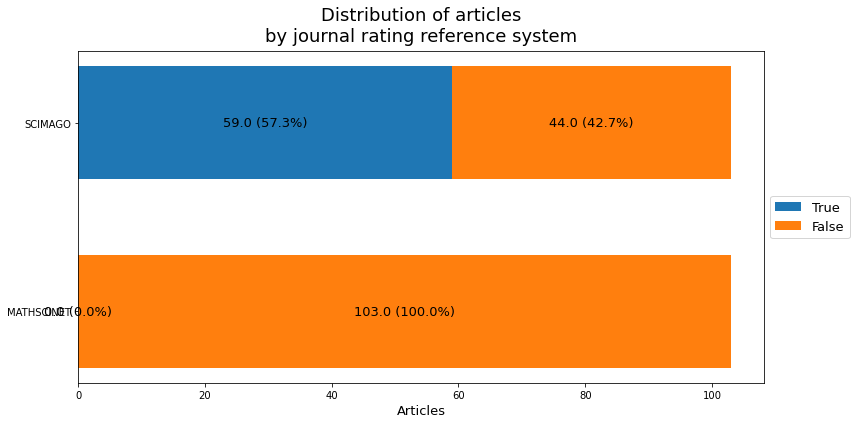

[2023-03-03 14:43:47][WARNING][hceres_ranking_plot#6] Skip plotting HCERES as "HCERES_RANK" is not a column of the DataFrame
[2023-03-03 14:43:47][WARNING][cnrs_s37_ranking_plot#6] Skip plotting CNRS_S37 as "CNRS_S37_CAT" is not a column of the DataFrame
[2023-03-03 14:43:47][INFO ][cross_referentials_plot#27] Saved figure at "./exports/rankings_cri_distribution_of_articles_in_journal_classification_referentials.png"


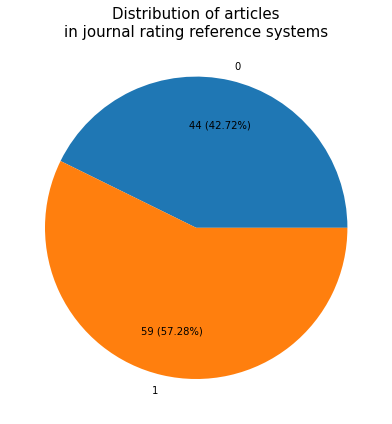

[2023-03-03 14:43:47][INFO ][scimago_rankings#8] Process scimago rankings (filename_prefix=rankings_cri, titles={'Scimago JCR: categories': 'Distribution of articles by category\nfor the Scimago JCR rating reference system', 'Scimago JCR: quartiles': 'Distribution of articles by quartiles\nfor the Scimago JCR rating reference system'})
[2023-03-03 14:43:47][INFO ][create_scimajo_df#19] Saved CSV at "./exports/rankings_cri_scimago.csv"
[2023-03-03 14:43:47][INFO ][create_scimajo_df#31] Saved CSV at "./exports/rankings_cri_scimago_filtered_0.csv
[2023-03-03 14:43:47][INFO ][scimago_ranking_plot#38] Saved figure at "./exports/rankings_cri_scimago_categories_0.png"


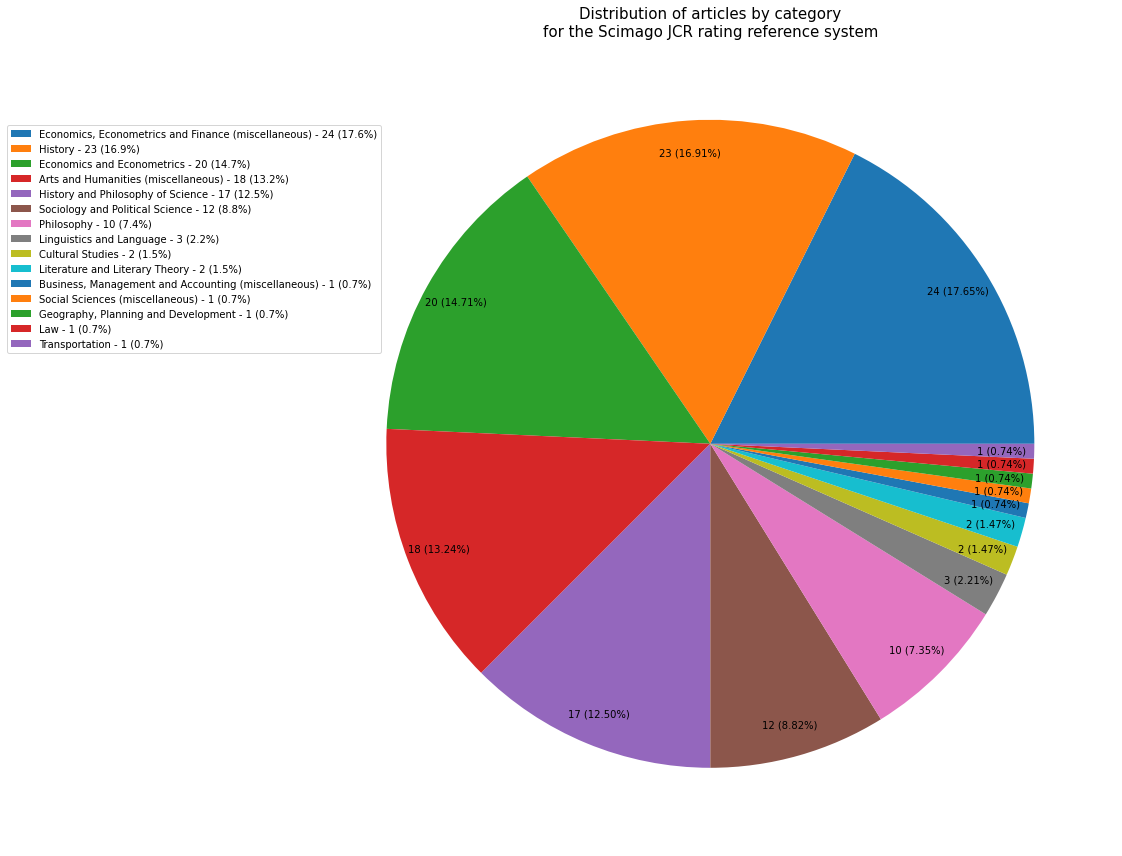

[2023-03-03 14:43:47][INFO ][scimago_ranking_plot#64] Saved figure at "./exports/rankings_cri_scimago_sjr_q_score_0.png"


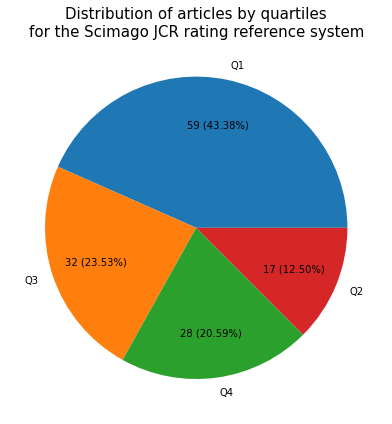

,uri_s,journalTitle_s,journalIssn_s,MATHSCINET,SCIMAGO_CATEGORIES,SJR_BEST_QUARTILE,SCIMAGO,NUMBER_OF_REFERENTIALS
0,https://shs.hal.science/halshs-03515973,History of Economic Ideas,1122-8792,False,History (Q1); Economics and Econometrics (Q3);...,Q1,True,1
1,https://shs.hal.science/halshs-01740553,Proceedings of the Aristotelian Society,0066-7374,False,Philosophy (Q1),Q1,True,1
2,https://hal.archives-ouvertes.fr/hal-03915312,History of Economic Ideas,1122-8792,False,History (Q1); Economics and Econometrics (Q3);...,Q1,True,1
3,https://hal.science/hal-03209945,Journal of the History of Economic Thought,1053-8372,False,Arts and Humanities (miscellaneous) (Q2); Econ...,Q2,True,1
4,https://hal-paris1.archives-ouvertes.fr/hal-03...,XVII-XVIII Revue de la Société d'études anglo-...,2117-590X,False,NaN,NaN,False,0
...,...,...,...,...,...,...,...,...
98,https://hal.science/hal-03933394,Observatoire de la société britannique,1957-3383,False,NaN,NaN,False,0
99,https://hal.science/hal-02988080,History of Economic Ideas,1122-8792,False,History (Q1); Economics and Econometrics (Q3);...,Q1,True,1
100,https://hal-paris1.archives-ouvertes.fr/hal-03...,Real-World Economics Review,NaN,False,NaN,NaN,False,0
101,https://hal-paris1.archives-ouvertes.fr/hal-03...,European Journal of the History of Economic Th...,0967-2567,False,Arts and Humanities (miscellaneous) (Q1); Econ...,Q1,True,1


In [64]:
ranking_df = rankings(
    dataframe = df_art,
    filename_prefix = 'rankings_cri',
    excludes = ['HCERES', 'ECONLIT', 'CNRS_S37'],
    titles = {
        'Articles ranking': 'Distribution of articles\nby journal rating reference system',
        'Distribution of articles': 'Distribution of articles\nin journal rating reference systems',
    }
)
scimago_rankings(
    dataframe = ranking_df,
    filename_prefix = 'rankings_cri',
    quantile = 0,
    titles = {
        'Scimago JCR: categories': 'Distribution of articles by category\nfor the Scimago JCR rating reference system',
        'Scimago JCR: quartiles':  'Distribution of articles by quartiles\nfor the Scimago JCR rating reference system',
    }
)
ranking_df

### Without MATHSCINET (PHARE)

[2023-03-03 14:43:47][INFO ][rankings#7] Process ranking (filename_prefix=rankings_phare, titles={'Articles ranking': 'Distribution of articles\nby journal rating reference system', 'HCERES articles ranking': 'Distribution of articles\nfor the HCERES Vague C 2021 rating reference system', 'Distribution of articles': 'Distribution of articles\nin journal rating reference systems'})
[2023-03-03 14:43:47][INFO ][create_ranking_journals_df#6] Create ranking dataframe including: ['ECONLIT', 'SCIMAGO', 'HCERES', 'CNRS_S37'] (excludes=['MATHSCINET'])
[2023-03-03 14:43:47][INFO ][csv#35] Export to CSV file: ./exports/rankings_phare.csv (params: {'index': False}) (number of rows: 103)
[2023-03-03 14:43:47][INFO ][csv#35] Export to CSV file: ./exports/rankings_phare_filtered.csv (params: {'index': False}) (number of rows: 103)
[2023-03-03 14:43:47][INFO ][csv#35] Export to CSV file: ./exports/rankings_phare_count.csv (params: {'index': False}) (number of rows: 4)
[2023-03-03 14:43:48][INFO ][jou

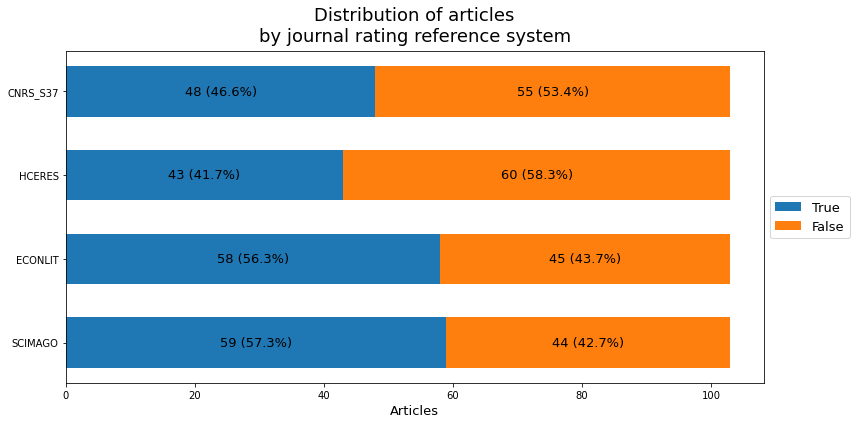

[2023-03-03 14:43:48][INFO ][hceres_ranking_plot#14] Create ranking plot "Distribution of articles
for the HCERES Vague C 2021 rating reference system" for HCERES (params={})
[2023-03-03 14:43:48][INFO ][csv#35] Export to CSV file: ./exports/rankings_phare_hceres.csv (params: {'index': False}) (number of rows: 3)
[2023-03-03 14:43:48][INFO ][hceres_ranking_plot#35] Saved figure at "./exports/rankings_phare_hceres.png"


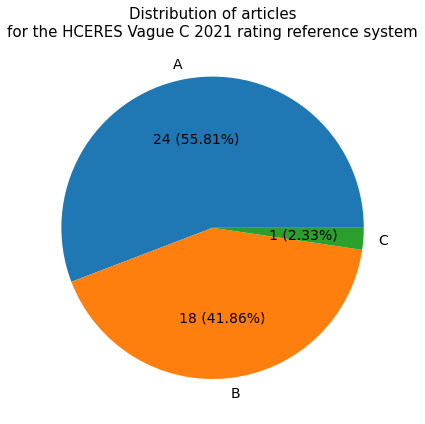

[2023-03-03 14:43:48][INFO ][cnrs_s37_ranking_plot#14] Create ranking plot "CNRS S37 articles ranking" for CNRS (params={})
[2023-03-03 14:43:48][INFO ][csv#35] Export to CSV file: ./exports/rankings_phare_rankings_phare_cnrs_s37.csv (params: {'index': False}) (number of rows: 4)
[2023-03-03 14:43:48][INFO ][pie#127] Export pie graph to PNG file: ./exports/rankings_phare_cnrs_s37_articles_ranking.png


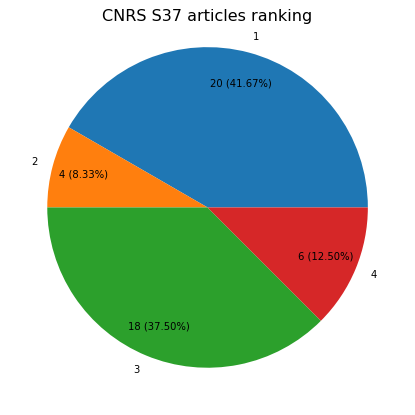

[2023-03-03 14:43:48][INFO ][cross_referentials_plot#27] Saved figure at "./exports/rankings_phare_distribution_of_articles_in_journal_classification_referentials.png"


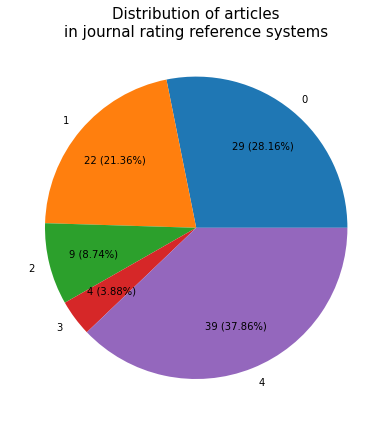

[2023-03-03 14:43:48][INFO ][scimago_hceres_matrix#8] Create Scimago / HCERES matrix
[2023-03-03 14:43:48][INFO ][scimago_hceres_matrix#13] Saved Excel at "./exports/rankings_phare_hceres_scimago_matrix.xlsx"
[2023-03-03 14:43:48][INFO ][scimago_hceres_matrix#17] Saved Excel at "./exports/rankings_phare_hceres_scimago_matrix_2.xlsx"
[2023-03-03 14:43:48][INFO ][scimago_rankings#8] Process scimago rankings (filename_prefix=rankings_phare, titles={'Scimago JCR: categories': 'Distribution of articles by category\nfor the Scimago JCR rating reference system', 'Scimago JCR: quartiles': 'Distribution of articles by quartiles\nfor the Scimago JCR rating reference system'})
[2023-03-03 14:43:48][INFO ][create_scimajo_df#19] Saved CSV at "./exports/rankings_phare_scimago.csv"
[2023-03-03 14:43:48][INFO ][create_scimajo_df#31] Saved CSV at "./exports/rankings_phare_scimago_filtered_0.csv
[2023-03-03 14:43:48][INFO ][scimago_ranking_plot#38] Saved figure at "./exports/rankings_phare_scimago_categ

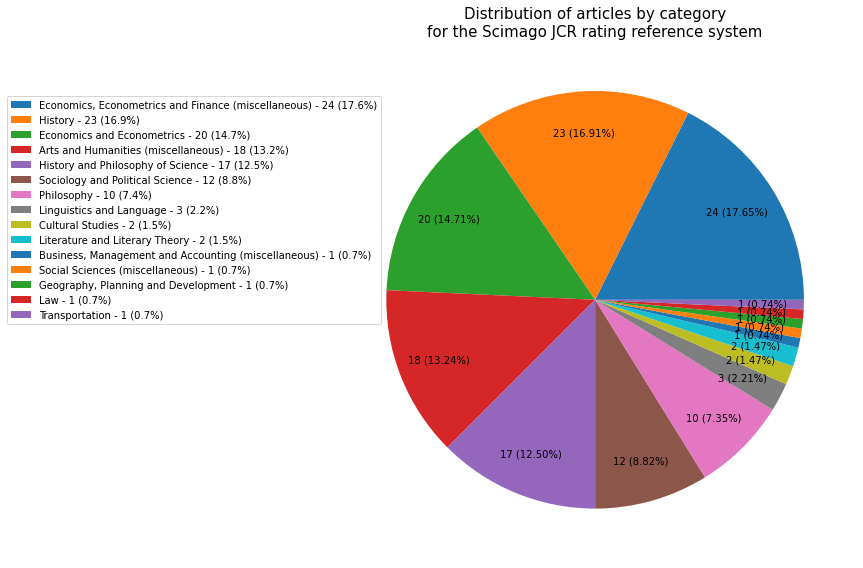

[2023-03-03 14:43:48][INFO ][scimago_ranking_plot#64] Saved figure at "./exports/rankings_phare_scimago_sjr_q_score_0.png"


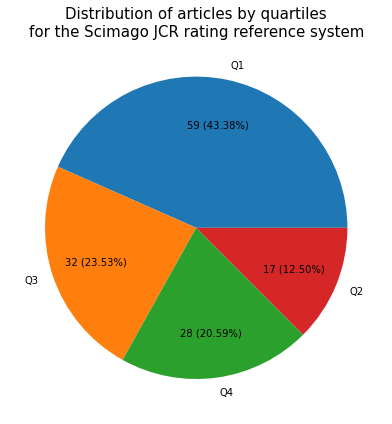

,uri_s,journalTitle_s,journalIssn_s,URL,ECONLIT,SCIMAGO_CATEGORIES,SJR_BEST_QUARTILE,SCIMAGO,HCERES_CONRS_RANK,HCERES_FNEGE_RANK,HCERES_RANK,HCERES,CNRS_S37_DOMAINE,CNRS_S37_CAT,CNRS_S37,NUMBER_OF_REFERENTIALS
0,https://shs.hal.science/halshs-03515973,History of Economic Ideas,1122-8792,http://www.libraweb.net/sommari.php?chiave=61,True,History (Q1); Economics and Econometrics (Q3);...,Q1,True,3,NaN,B,True,HPEA,3,True,4
1,https://shs.hal.science/halshs-01740553,Proceedings of the Aristotelian Society,0066-7374,NaN,False,Philosophy (Q1),Q1,True,NaN,NaN,NaN,False,NaN,NaN,False,1
2,https://hal.archives-ouvertes.fr/hal-03915312,History of Economic Ideas,1122-8792,http://www.libraweb.net/sommari.php?chiave=61,True,History (Q1); Economics and Econometrics (Q3);...,Q1,True,3,NaN,B,True,HPEA,3,True,4
3,https://hal.science/hal-03209945,Journal of the History of Economic Thought,1053-8372,http://journals.cambridge.org/action/displayBa...,True,Arts and Humanities (miscellaneous) (Q2); Econ...,Q2,True,NaN,NaN,NaN,False,NaN,NaN,False,2
4,https://hal-paris1.archives-ouvertes.fr/hal-03...,XVII-XVIII Revue de la Société d'études anglo-...,2117-590X,NaN,False,NaN,NaN,False,NaN,NaN,NaN,False,NaN,NaN,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,https://hal.science/hal-03933394,Observatoire de la société britannique,1957-3383,NaN,False,NaN,NaN,False,NaN,NaN,NaN,False,NaN,NaN,False,0
99,https://hal.science/hal-02988080,History of Economic Ideas,1122-8792,http://www.libraweb.net/sommari.php?chiave=61,True,History (Q1); Economics and Econometrics (Q3);...,Q1,True,3,NaN,B,True,HPEA,3,True,4
100,https://hal-paris1.archives-ouvertes.fr/hal-03...,Real-World Economics Review,NaN,NaN,True,NaN,NaN,False,NaN,NaN,NaN,False,NaN,NaN,False,1
101,https://hal-paris1.archives-ouvertes.fr/hal-03...,European Journal of the History of Economic Th...,0967-2567,http://www.tandfonline.com/loi/rejh20,True,Arts and Humanities (miscellaneous) (Q1); Econ...,Q1,True,1,3,A,True,HPEA,1,True,4


In [65]:
ranking_df = rankings(
    dataframe = df_art,
    filename_prefix = 'rankings_phare',
    excludes = ['MATHSCINET'],
    titles = {
        'Articles ranking': 'Distribution of articles\nby journal rating reference system',
        'HCERES articles ranking': 'Distribution of articles\nfor the HCERES Vague C 2021 rating reference system',
        'Distribution of articles': 'Distribution of articles\nin journal rating reference systems',
    }
)
scimago_hceres_matrix(dataframe = ranking_df, filename_prefix = 'rankings_phare')
scimago_rankings(
    filename_prefix = 'rankings_phare',
    dataframe = ranking_df,
    quantile = 0,
    titles = {
        'Scimago JCR: categories': 'Distribution of articles by category\nfor the Scimago JCR rating reference system',
        'Scimago JCR: quartiles':  'Distribution of articles by quartiles\nfor the Scimago JCR rating reference system',
    },
    category_params = dict(
        figsize = (12,8),
        pctdistance = 0.8
    )
)
ranking_df

## Peer reviewing

[2023-03-03 14:43:48][INFO ][csv#35] Export to CSV file: ./exports/articles-peer-reviewing.csv (params: {'index': True}) (number of rows: 2)
[2023-03-03 14:43:48][INFO ][pie#127] Export pie graph to PNG file: ./exports/discribution_of_articles_with_peer_reviewing.png


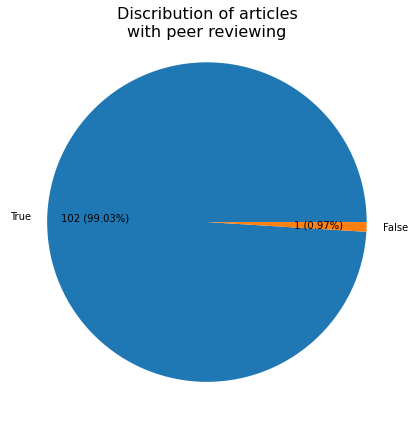

,peerReviewing_s,count
0,True,102
1,False,1


In [66]:
peer_reviewing = df_art[['uri_s', 'peerReviewing_s']].fillna(0).astype({'peerReviewing_s': 'int'})
peer_reviewing['peerReviewing_s'] = peer_reviewing.apply(func=lambda r: r['peerReviewing_s'] == 1, axis='columns')
DfOps(peer_reviewing) \
    .count(subset=['peerReviewing_s'], column='count') \
    .csv('articles-peer-reviewing.csv') \
    .pie(
        column='count',
        label_column='peerReviewing_s',
        title='Discribution of articles\nwith peer reviewing',
        plot_params=dict(figsize=(6,6), pctdistance=0.7),
        sort_params=dict(ascending=False)
    )